# Lecture 2: *Bivariate Optimization*

The goal of this lecture is to generalize our theory of optimization over $\mathbb{R}$ to optimization over $\mathbb{R}^2$. Once we have an intution behind optimization over $\mathbb{R}^2$, we'll be much better equipped to deal with optimization over the general Euclidean spaces, $\mathbb{R}^n$. To create nice visualizations, we'll use Mathbox2.

In [1]:
'''
This code imports numpy packages and allows us to pass data from python to global javascript
objects. It was developed by znah@github
'''

import json
import numpy as np
import numpy.random as rd
from ipywidgets import widgets
from IPython.display import HTML, Javascript, display

def json_numpy_serializer(o):
    if isinstance(o, np.ndarray):
        return o.tolist()
    raise TypeError("{} of type {} is not JSON serializable".format(repr(o), type(o)))

def jsglobal(**params):
    code = [];
    for name, value in params.items():
        jsdata = json.dumps(value, default=json_numpy_serializer)
        code.append("window.{}={};".format(name, jsdata))
    display(Javascript("\n".join(code)))

In [2]:
%%javascript

// Loading the compiled MathBox bundle.
require.config({
    //baseUrl:'', paths: { mathBox: '../../tree/static/mathbox/build/mathbox-bundle'}
    // online compilation
    baseUrl: '', paths: {mathBox: '../static/mathbox/build/mathbox-bundle'}
    // online compilation without local library-- remove baseUrl
    //paths: {mathBox: '//cdn.rawgit.com/unconed/mathbox/eaeb8e15/build/mathbox-bundle'}
});

// Helper function that setups WebGL context and initializes MathBox.
window.with_mathbox = function(element, func) {
    require(['mathBox'], function(){
        var mathbox = mathBox({
          plugins: ['core', 'controls', 'cursor', 'mathbox'],
          controls: { klass: THREE.OrbitControls },
          mathbox: {inspect: false},
          element: element[0],
          loop: {start: false},
            
        });
        
        var three = mathbox.three;
        three.renderer.setClearColor(new THREE.Color(0xFFFFFF), 1.0);
        three.camera.position.set(-1, 1, 2);
        three.controls.noKeys = true;
        
        three.element.style.height = "400px";
        three.element.style.width = "100%";
        
        function isInViewport(element) {
          var rect = element.getBoundingClientRect();
          var html = document.documentElement;
          var w = window.innerWidth || html.clientWidth;
          var h = window.innerHeight || html.clientHeight;
          return rect.top < h && rect.left < w && rect.bottom > 0 && rect.right > 0;
        }
        
        // Running update/render loop only for visible plots.
        var intervalId = setInterval(function(){
            if (three.element.offsetParent === null) {
                clearInterval(intervalId);
                three.destroy();
                return;
            }
            var visible = isInViewport(three.canvas);
            if (three.Loop.running != visible) {
                visible? three.Loop.start() : three.Loop.stop();
            }
        }, 100);

        func(mathbox);
        
        window.dispatchEvent(new Event('resize'));
    })
};

// Function for setting up 3D axes and plotting the graph of a 2D function f
window.plotGraph = function(mathbox, f, xlabel='x', ylabel='y', zlabel='f(x,y)', rng=[[-3, 3], [-5, 5], [-3, 3]]) {
    
    var view = mathbox.cartesian({range: rng,
                                  scale: [1, 1, 1]},
                                  {rotation:(t)=>[0, t*0.02, 0]}
                                ).grid({axes: [1, 3]})
     
    view.area({id: 'yaxis',
               width: 1,
               height: 1,
               axes: [1, 3], 
               expr: function (emit, x, y, i, j) {
                   emit(4, 0, 0);
                   emit(0, 0, 0);
               },
               items: 2,
               channels: 3,
              })
        .text({font: 'Helvetica',
               style: 'bold',
               width:  16,
               height: 5,
               depth:  2,
               expr: function (emit, i, j, k, time) {
                   emit(ylabel);
               },
              })
        .label({color: '#000000',
                snap: false,
                outline: 2,
                size: 24,
                offset: [0, -32],
                depth: .5,
                zIndex: 1
               });
              
    view.vector({points: '#yaxis',
                 color: 0x000000,
                 width: 9,
                 start: true
                });
    
    view.area({id: 'xaxis',
               width: 1,
               height: 1,
               axes: [1, 3],
               expr: function (emit, x, y, i, j) {
                   emit(0, 0, 4);
                   emit(0, 0, 0);
               },
               items: 2,
               channels: 3,
              })
        .text({font: 'Helvetica',
               style: 'bold',
               width:  16,
               height: 5,
               depth:  2,
               expr: function (emit, i, j, k, time) {
                   emit(xlabel);
               },
              })
        .label({color: '#000000',
                snap: false,
                outline: 2,
                size: 24,
                offset: [0, -32],
                depth: .5,
                zIndex: 1,
               });
              
    view.vector({points: '#xaxis',
                 color: 0x000000,
                 width: 9,
                 start: true,
                });
    
    view.area({id: 'zaxis',
               width: 1,
               height: 1,
               axes: [1, 3],
               expr: function (emit, x, y, i, j) {
                   emit(0, 4, 0);
                   emit(0, 0, 0);
               },
               items: 2,
               channels: 3,
              })
        .text({font: 'Helvetica',
               style: 'bold',
               width:  16,
               height: 5,
               depth:  2,
               expr: function (emit, i, j, k, time) {
                   emit(zlabel);
               },
              })
        .label({color: '#000000',
                snap: false,
                outline: 2,
                size: 24,
                offset: [0, -32],
                depth: .5,
                zIndex: 1,
               });

    view.vector({points: '#zaxis',
                 color: 0x000000,
                 width: 9,
                 start: true,
                });
    
    var graph = view.area({id:'graph',
                             width: 64,
                             height: 64,
                             axes: [1, 3],
                             expr: function (emit, y, x, i, j) {
                                 emit(y, f(x, y), x);
                             },
                             items: 1,
                             channels: 3,
                            });
    
    view.surface({shaded: true,
                  lineX: true,
                  lineY: true,
                  points: graph,
                  color: 0x0000FF,
                  width: 1,
                 });
    
    return view;
};

window.addSegment = function(view, p0, p1, col) {
    
    view.array({width: 128,
                expr: function (emit, i, time) {
                    var b = i/128;
                    var a = 1-b;
                    emit(a*p0[1] + b*p1[1], a*p0[2] + b*p1[2], a*p0[0] + b*p1[0]);
                },
                channels: 3,
               });

    view.line({color: col,
               width: 10,
               size: 2.5,
               stroke: 'dotted',
               start: false,
               end: false,
              });
    
};

window.addPoint = function(view, p, col, label) {
    view.array({width: 4,
                items: 2,
                channels: 3,
                expr: function (emit, i, t) {
                    emit(p[1],p[2],p[0]);
                },
               })
        .point({color:  col,
                points: '<',
                size: 15,
                depth: .5,
                zBias: 50,
               })
        .text({font: 'Helvetica',
               style: 'bold',
               width:  16,
               height: 5,
               depth:  2,
               expr: function (emit, i, j, k, time) {
                   emit(label);
               },
              })
        .label({color: col,
                snap: false,
                outline: 2,
                size: 24,
                offset: [0, -32],
                depth: .5,
                zIndex: 1,
               });
};

window.addCurve = function(view, ab, x, y, z, col) {
    
    view.array({width: 128,
                expr: function (emit, i, time) {
                    var t = (ab[1]-ab[0])*(i/128) + ab[0];
                    emit(y(t), z(t), x(t));
                },
                channels: 3,
               });

    view.line({color: col,
               width: 20,
               size: 2.5,
               start: true,
               end: true,
              });
};

window.addClosedCurve = function(view, ab, x, y, z, col) {
    
    view.array({width: 128,
                expr: function (emit, i, time) {
                    var t = (ab[1]-ab[0])*(i/128) + ab[0];
                    emit(y(t), z(t), x(t));
                },
                channels: 3,
               });

    view.line({color: col,
               width: 20,
               size: 2.5,
               start: false,
               end: false,
              });
};


window.addSurface = function(view, ab, cd, x, y, z, col, opa) {
    
    view.matrix({width: 64,
                 height: 64,
                 expr: function (emit, i, j, time) {
                     var p = (ab[1]-ab[0])*(i/64) + ab[0];
                     var q = (cd[1]-cd[0])*(j/64) + cd[0];
                     emit(y(p, q), z(p, q), x(p, q));
                 },
                 items: 1,
                 channels: 3
                })
        .surface({shaded: true,
                  lineX: false,
                  lineY: false,
                  color: col,
                  width: 1,
                  opacity: opa
                 });
}

window.addSequence = function(view, seq, col) {
    
    var idx = 0;
    var d = new Date();
    var start = d.getTime();
    view.array({width: 1,
                expr: function (emit, i, time) {
                    var nd = new Date();
                    var now = nd.getTime();
                    if (1000 < now-start) {
                        idx = idx + 1;
                        if (seq.length <= idx) {
                            idx = 0;
                        }
                        start = now;
                    }
                    emit(seq[idx][1], seq[idx][2], seq[idx][0]);    
                },
                items: 1,
                channels: 3
               }) 
        .point({color:  col,
                points: '<',
                size: 15,
                depth: .5,
                zBias: 50,
                });
    
}


<IPython.core.display.Javascript object>

# Part I: Preliminaries and Definitions
We let 
$$
\mathbb{R}^2 =\{(x,\:y):x,y\in\mathbb{R}\}
$$
denote the Euclidean plane, which consists of all ordered pairs of real numbers. Sometimes the ordered pairs will take the form ${\bf x}=(x_1,\:x_2)$, in which case the individual **entries** or **components** of ${\bf x}$ are $x_1$ and $x_2$. That is, $x_1$ is the first entry or component of ${\bf x}$ and $x_2$ is the second.

Just as $f:\mathbb{R}\rightarrow\mathbb{R}$ can be represented by the graph
$$
\{(x, f(x)): x\in\mathbb{R}\}\subset\mathbb{R}^2,
$$
a bivariate function $f:\mathbb{R}^2\rightarrow\mathbb{R}$ can be represented by the graph
$$
\{(x, y, f(x, y): (x,y)\in\mathbb{R}^2\}\subset\mathbb{R}^3.
$$

In [3]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return (1 + 8*y*y + Math.pow(x-2,2)*(Math.pow(x+2,2)+1))/20;
    }
    
    var view = plotGraph(mathbox, fcn);
    
})


<IPython.core.display.Javascript object>

It is easy enough to see that the reflection principle also applies when we optimize over $\mathbb{R}^2$; a maximizer of $f(x,y)$ over $\mathbb{R}^2$ is also a minimizer of $-f(x,y)$ over $\mathbb{R}^2$. Thus, an unconstrained optimization program involving $f:\mathbb{R}^2\rightarrow\mathbb{R}$ is generally expressed as
$$
(P):\:\:\min_{(x,y)\in\mathbb{R}^2} f(x,y).
$$
A **solution** to this program is any $(x^\ast,y^\ast)\in\mathbb{R}^2$ satisfying $f(x^\ast,y^\ast)\leq f(x, y)$ for any $x,y\in\mathbb{R}^2$, and two programs are **equivalent** if they have the same solutions. Note that, if $\phi:\mathbb{R}\rightarrow\mathbb{R}$ is **order preserving**, then
$$
\min_{(x,y)\in\mathbb{R}^2} \phi(f(x,y))
$$
is equivalent to $(P)$. Furthermore, the **minimum value** of $f:\mathbb{R}^2\rightarrow\mathbb{R}$ is any value $p$ such that $p\leq f(x,y)$ for all $(x,y)\in\mathbb{R}^2$ and if $y\leq f(x,y)$ for all $(x,y)\in\mathbb{R}^2$ then $y\leq p$.

## Constrained Bivariate Optimization

Constrained optimization becomes much more complicated in $\mathbb{R}^2$. We will often consider some subset $X\subset\mathbb{R}^2$ and a function $f:X\rightarrow\mathbb{R}$, where $X$ is determined by other functions. That is, $X$ will be specified by identifying functions $g_1, g_2, \ldots, g_n:\mathbb{R}^2\rightarrow\mathbb{R}$ and $h_1, h_2,\ldots, h_m:\mathbb{R}^2\rightarrow\mathbb{R}$ so that

$$
X = \{(x,y)\in\mathbb{R}^2: g_i(x,y)=0\text{ and }h_j(x,y)\leq 0\text{ for all }i=1,\ldots,n\text{ and }j=1,\ldots, m\}.
$$

1. We call the constraints $g_i(x,y)=0$ **equality constraints**
2. We call the constraints $h_j(x,y)\leq 0$ **inequality constraints**

A constrained optimization program is then expressed as
$$
\min f(x,y)\text{ subject to } g_i(x,y)=0\text{ and }h_j(x,y)\leq 0\text{ for all }i=1,\ldots, n\text{ and }j=1,\ldots, m.
$$
The set $X$ is called the **feasible region**. The program is called **feasible** if $X\not=\emptyset$, and is called **infeasible** otherwise. A point $(x, y)\in X$ is called a **feasible point** or simply **feasible**. If $(x,y)\in X$ and $h_j(x,y)<0$ for all $j=1,\ldots, m$, then $(x,y)$ is called **strictly feasible**. 

### Example: 
$$
\min 2x^2 + 2xy + 2y^2\text{ subject to } x^2+y^2=1,\: x\geq 0,\text{ and }y\geq 0.
$$

The path to understanding constrained optimization over $\mathbb{R}^2$ passes through a thorough understanding of unconstrained optimization over $\mathbb{R}^2$. We will return to this topic when we have the necessary tools to make sense of things.

## Group Problems
1.

# Part II: Important considerations

Our concerns for bivariate optimization are the same as in the univariate case.

1. Does $(P)$ have a minimum value?
2. Does $(P)$ have a solution?
3. Does $(P)$ have a **unique** solution?
4. When $(P)$ has a minimum value, how can we find an $(\widetilde{x},\widetilde{y})$ such that $f(\widetilde{x},\widetilde{y})$ is close to the minimum value?
5. When $(P)$ has a solution $(x^\ast, y^\ast)$, how can we find an $(\widetilde{x},\widetilde{y})$ which is close to $(x^\ast, y^\ast)$?

We will explore how the answers to these questions differ from the univariate case.


# Part III: Existence of minimum values and minimizers

If there is an $L\in\mathbb{R}$ such that $L\leq f(x,y)$ for all $(x,y)\in\mathbb{R}$, then $f$ is said to be **bounded below**.

#### Theorem: If $f:\mathbb{R}^2\rightarrow\mathbb{R}$ is bounded below, then $(P)$ has a minimum value.

Our next goal is to generalize the Extreme Value Theorem, but first we must generalize the notion of continuity. To do this, we introduce the **Euclidean norm**, $\Vert\bullet\Vert:\mathbb{R}^2\rightarrow\mathbb{R}$ defined by

$$
\Vert (x, y)\Vert = \sqrt{x^2 + y^2}.
$$

The Euclidean norm measures the distance from the origin $(0,0)$ to the point $(x,y)$ in $\mathbb{R}^2$. The properties of the Euclidean norm are incredibly important, and are best understood in terms of the **vector space structure** on $\mathbb{R}$. 

## Vector Space Structure of $\mathbb{R}^2$

We define scalar multiplication and vector addition on $\mathbb{R}^2$ by
$$
a\cdot(x_1,x_2)=(ax_1, ax_2)\text{ and }(x_1,x_2)+(y_1,y_2)=(x_1+y_1, x_2+y_2)
$$
respectively for all $a\in\mathbb{R}$ and all $(x_1, x_2),(y_1,y_2)\in\mathbb{R}^2$. The following algebraic properties hold:
1. Vector addition is **associative**: $((x_1,x_2)+(y_1,y_2))+(z_1,z_2)=(x_1,x_2)+((y_1,y_2)+(z_1,z_2))$ for all $(x_1,x_2), (y_1, y_2), (z_1, z_2)\in\mathbb{R}^2$
2. Vector addition is **commutative**: $(x_1, x_2)+(y_1, y_2)=(y_1, y_2)+(x_1,x_2)$ for all $(x_1,x_2), (y_1, y_2)\in\mathbb{R}^2$. 
3. An **additive identity element** exists: the origin $(0,0)\in\mathbb{R}^2$ satisfies $(0, 0)+(x,y)=(x,y)$ for all $(x,y)\mathbb{R}^2$
4. All elements $(x, y)\in\mathbb{R}^2$ have an **additive inverse**: $(x,y)+(-x,-y)=(0,0)$ for all $(x,y)\in\mathbb{R}^2$.
5. Scalar multiplication is **compatible** with standard multiplication: $a\cdot(b\cdot(x,y))=(a\cdot b)\cdot(x,y)$ for all $(x,y)\in\mathbb{R}^2$ and all $a,b\in\mathbb{R}$.
6. A **scalar identity element** exists: $1\in\mathbb{R}$ satisfies $1\cdot(x,y)=(x,y)$ for all $(x,y)\in\mathbb{R}$.
7. Scalar multiplication is distributive with respect to vector addition: $a\cdot((x_1,x_2)+(y_1,y_2))=a\cdot(x_1,x_2) + a\cdot(y_1,y_2)$ for all $a\in\mathbb{R}$ and all $(x_1,x_2), (y_1,y_2)\in\mathbb{R}^2$.
8. Scalar multiplication is distributive with respect to scalar addition: $(a+b)\cdot(x, y)=a\cdot(x,y)+b\cdot(x,y)$ for all $a,b\in\mathbb{R}$ and all $(x,y)\in\mathbb{R}$.

Scalar multiplication and vector addition also have very intuitive geometric interpretations.

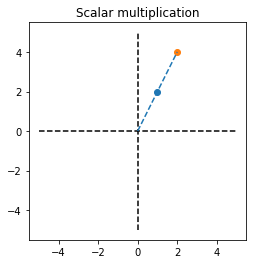

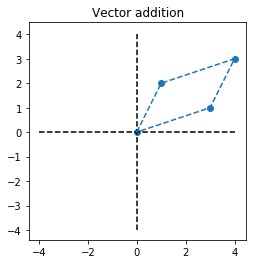

In [4]:
'''
Example 1: Scalar multiplication and vector addition
'''
import matplotlib.pyplot as plt

x=np.array([1, 2])
a = 2
v = a * x

plt.plot([-5, 5], [0, 0], 'k--')
plt.plot([0, 0], [-5, 5], 'k--')
plt.plot([0, 2], [0, 4], '--')
plt.scatter([x[0]], [x[1]])
plt.scatter([v[0]], [v[1]])
plt.axis('square')
plt.title('Scalar multiplication')
plt.show()

x=np.array([1, 2])
y=np.array([3, 1])
z=x+y

plt.plot([-4, 4], [0, 0], 'k--')
plt.plot([0, 0], [-4, 4], 'k--')
plt.plot([0, x[0], z[0], y[0], 0], [0, x[1], z[1], y[1], 0], '--')
plt.scatter([0, x[0], z[0], y[0]], [0, x[1], z[1], y[1]])
plt.axis('square')
plt.title('Vector addition')
plt.show()

It should be noted that we shall use the notation $(x_1, x_2)-(y_1, y_2)=(x_1-y_1, x_2-y_2)$. 

Now, the Euclidean norm is a **norm** because it satisfies the following properties:

1. (Positivity): $\Vert (x, y)\Vert\geq 0$ for all $(x,y)\in\mathbb{R}^2$ and $\Vert(x,y)\Vert=0$ only if $(x,y)=(0,0)$.
2. (Homogeneity): $\Vert a\cdot (x, y)\Vert=\vert a\vert\Vert(x, y)\Vert$ for all $a\in\mathbb{R}$ and all $(x,y)\in\mathbb{R}^2$.
3. (Triangle Inequality): $\Vert (x_1, x_2) + (y_1, y_2)\Vert \leq \Vert (x_1, x_2)\Vert+\Vert (y_1, y_2)\Vert$ for all $(x_1, x_2), (y_1, y_2)\in\mathbb{R}^2$.

One can go back and check that the absolute value $\vert\cdot\vert$ is a norm on $\mathbb{R}$. In particular, the Euclidean norm gives us a way to generalize the $\varepsilon$-neighborhoods, $(x-\varepsilon, x+\varepsilon)=\{y\in\mathbb{R}: \vert x-y\vert<\varepsilon\}$. For $\varepsilon>0$, the **$\varepsilon$-ball** around ${\bf x}\in\mathbb{R}$ is the set 

$$
B({\bf x},\varepsilon)=\{{\bf y}\in\mathbb{R}^2: \Vert {\bf x}-{\bf y}\Vert<\varepsilon\}.
$$

Given $X\subset\mathbb{R}^2$, $f:X\rightarrow\mathbb{R}$ is said to be **continuous at** ${\bf x}^{(0)}\in\mathbb{R}^2$ if for every $\varepsilon>0$ there is a $\delta>0$ such that $\vert f({\bf y})-f({\bf x})\vert<\varepsilon$ for all ${\bf y}\in B({\bf x},\delta)\cap X$. $f$ is **continuous** on $X$ (or just **continuous**) if $f$ is continuous at all ${\bf x}\in X$.

For $X\subset\mathbb{R}^2$, a subset $U\subset X$ is called **open** in $X$ if for every ${\bf x}\in U$ there is an $\varepsilon>0$ such that $B({\bf x},\varepsilon)\cap X\subset U$. A subset $Q\subset\mathbb{R}^2$ is called **closed** in $X$ if its complement
$$
\overline{Q}=\{{\bf x}\in X: x\not\in Q\}
$$
is open in $X$. The following theorem is very helpful for constrained optimization over $\mathbb{R}^2$.

#### Theorem: $Q\subset\mathbb{R}$ is closed if and only if there is a continuous function $f:\mathbb{R}^2\rightarrow\mathbb{R}$ such that $Q=\{{\bf x}\in\mathbb{R}^2: f({\bf x})=0\}$ or $Q=\{{\bf x}\in\mathbb{R}^2:f({\bf x})\leq 0\}$.


A set $X\subset\mathbb{R}^2$ is said to be **bounded** if there is an $R\in\mathbb{R}$ such that $X\subset B({\bf 0}, R)$.

A set $X\subset\mathbb{R}$ is **compact** if it is both closed and bounded. 

#### Theorem (Extreme Value Theorem): If $X\subset\mathbb{R}^2$ is compact and $f:X\rightarrow\mathbb{R}$ is continuous on $X$, then $f$ has a minimizer ${\bf x}^\ast\in X$.


# Part IV: Uniqueness of Solutions and Convexity
Uniqueness of solutions is generally contingent upon convexity of the optimization program. 

A set $X\subset\mathbb{R}^2$ is said to be **convex** if for any ${\bf x}, {\bf y}\in X$ and any $t\in[0,1]$, $(1-t){\bf x} + t{\bf y}\in X$. 

If $X\subset\mathbb{R}^2$ is a convex set:

1. $f:X\rightarrow\mathbb{R}$ is said to be **convex** on $X$ if for every ${\bf x}, {\bf y}\in X$ and every $t\in[0,1]$ we have that
$$
f((1-t){\bf x} + t{\bf y}) \leq (1-t)f({\bf x}) + t f({\bf y}).
$$ 
2. $f:X\rightarrow\mathbb{R}$ is said to be **strictly convex** on $X$ if for every ${\bf x}, {\bf y}\in X$ and every $t\in(0,1)$ we have that
$$
f((1-t){\bf x} + t{\bf y}) < (1-t)f({\bf x}) + t f({\bf y}).
$$ 


In [5]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
      return Math.sqrt(x*x + y*y);
    };
    
    var view = plotGraph(mathbox, fcn);
     
    addSegment(view, [2, -2, 0], [0, 0, 0], 0x3090FF);
    addPoint(view, [2, -2, 0], 0x000000, '(2,-2)');
    addPoint(view, [0, 0, 0], 0x000000, '(0, 0, 0)');
    
    addSegment(view, [2, -2, fcn(2, -2)], [0, 0, 0], 0x3090FF);
    addPoint(view, [2, -2, 2.838], 0x000000, '(2, -2, 2.838)');
     
})

<IPython.core.display.Javascript object>

In [6]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return (x*x + y*y)/2;
    }
    
    var view = plotGraph(mathbox, fcn)
    
    addSegment(view, [-2, 3, 0], [3, -1, 0], 0x3090FF);
    addPoint(view, [-2, 3, 0], 0x000000, '(-2, 3)');
    addPoint(view, [3, -1, 0], 0x000000, '(3, -1)');
    
    addSegment(view, [-2, 3, fcn(-2, 3)], [3, -1, fcn(3, -1)], 0x3090FF);
    addPoint(view, [-2, 3, fcn(-2, 3)], 0x000000, '(-2, 3, 6.5)');
    addPoint(view, [3, -1, fcn(3, -1)], 0x000000, '(3, -1, 5)');
     
})

<IPython.core.display.Javascript object>

We again have that strict convexity implies convexity, which in turn implies continuity.

#### Theorem (Convex Functions are Continuous): If $X\subset\mathbb{R}^2$ is convex and open, and $f:X\rightarrow\mathbb{R}$ is convex on $X$, then $f$ is continuous on $X$.

If $f$ is convex, then $(P)$ is called a **convex program**. 

Now, **strict minimizer**/**unique minimizer** of $f$ on $X$ is a point $(x^\ast, y^\ast)$ such that $f(x^\ast,y^\ast)<f(x,y)$ for all $(x,y)\in X\setminus\{(x^\ast,y^\ast)\}$. 

#### Theorem (Fundamental Theorem of Convex Programming): If $X\subset\mathbb{R}^2$ is convex, compact, and $f:X\rightarrow\mathbb{R}$ is  convex on $X$, then the set of minimizers of $f$ on $X$ form a convex set. Moreover, if $f$ strictly convex on $X$, then $f$ has a unique minimizer on $X$.

We now need to develop our theory of differentiation in two dimensions in order to generalize the first order conditions and the second order conditions for convexity. Recall that the first order conditions in 1D was equivalent to the fact that to the graph of the function dominates its tangent lines: $f(x)\geq f(y) + f^\prime(y)(x-y)$ for all $x,y\in\mathbb{R}$. For a function over $\mathbb{R}^2$, the analogous fact is that the tangent planes of the function are all dominated by the function. Thus, we seek equations for the tangent planes to $f:\mathbb{R}^2\rightarrow\mathbb{R}$. 

Much like a tangent line in $\mathbb{R}^2$ is specified by the equation of the form
$$
T_{x^{(0)}}(x)=m(x-x^{(0)})+b,
$$
a tangent plane in $\mathbb{R}^3$ is specified by the equation
$$
T_{(x^{(0)},y^{(0)}}(x, y) = m_x(x-x^{(0)}) + m_y(y-y^{(0)}) + b
$$
for $m_x, m_y, b\in\mathbb{R}$. Our tangent plane should take the value $f(x^{(0)},y^{(0)})$ at $(x^{(0)},y^{(0)})$, so we have that
$$
b = T_{(x^{(0)},y^{(0)}}(x^{(0)}, y^{(0)}) = f(x^{(0)},y^{(0)}).
$$
In particular, $\left(x^{(0)}, y^{(0)}, f(x^{(0)},y^{(0)})\right)$ is a point on the plane in $\mathbb{R}^3$, which is the graph of the function $T_{(x^{(0)},y^{(0)}}:\mathbb{R}^2\rightarrow\mathbb{R}$. To determine how the plane is oriented, we now only need to determine the values $m_x$ and $m_y$. Observe that
$$
t_x(x) = T_{(x^{(0)},y^{(0)}}(x, y^{(0)})=m_x(x-x_0)+b
$$
is $t:\mathbb{R}\rightarrow\mathbb{R}$. This function considers the behavior of the tangent plane when we keep $y=y^{(0)}$ fixed. Thus, $(x, y^{(0)}, t(x))$ is a line through the plane $\left(x, y, T_{(x^{(0)},y^{(0)}}(x, y)\right)$. Moreover, $t(x)$ should be tangent to the function
$$
\phi_x(x) = f(x,y^{(0)})
$$
at $x^{(0)}$. 

In [7]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return (x*x + y*y)/2;
    }
    
    var view = plotGraph(mathbox, fcn)
     
    addCurve(view,
             [-4, 4],
             function(t){return t;},  
             function(t){return 1},
             function(t){return fcn(t, 1)},
             0xFF8C00
            );
    
    addCurve(view,
             [-4, 4],
             function(t){return t;},  
             function(t){return 1},
             function(t){return 0},
             0x3090FF
            );
    
    addCurve(view,
             [-4, 4],
             function(t){return t;},  
             function(t){return 1},
             function(t){return 2*(t-2)+2.5},
             0xFF4500
            );
    
    addPoint(view, [2, 1, 0], 0x000000, '(2, 1)')
    addPoint(view, [2, 1, 2.5], 0xFF8C00, '(2, 1, 2.5)')
    
    addSurface(view, 
               [-4, 4],
               [-6, 6],
              function(s, t) {return s;},
              function(s, t) {return 1;},
              function(s, t) {return t;},
              0xAAAAAA,
              0.25)
   
    
})

<IPython.core.display.Javascript object>

In [8]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return (x*x + y*y)/2;
    }
    
    var view = plotGraph(mathbox, fcn);
     
    addCurve(view,
             [-4, 4],
             function(t){return 2;},
             function(t){return t;},
             function(t){return 0;},
             0x3090FF
            );
    
    addCurve(view,
             [-4, 4],
             function(t){return 2;},
             function(t){return t;},
             function(t){return fcn(2, t);},
             0xFF8C00
            );
    
    addCurve(view,
             [-4, 4],
             function(t){return 2;},
             function(t){return t;},
             function(t){return (t-1) + 2.5;},
             0xFF4500
            );
    
    addPoint(view, [2, 1, 0], 0x000000, '(2, 1)');
    addPoint(view, [2, 1, 2.5], 0xFF8C00, '(2, 1, 2.5)' );
    
    addSurface(view, 
               [-4, 4],
               [-6, 6],
              function(s, t) {return 2;},
              function(s, t) {return s;},
              function(s, t) {return t;},
              0xAAAAAA,
              0.25)
    
})

<IPython.core.display.Javascript object>

In [9]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return (x*x + y*y)/2;
    }
    
    var view = plotGraph(mathbox, fcn);
     
    addPoint(view, [2, 1, 0], 0x000000, '(2, 1)');
    addPoint(view, [2, 1, 2.5], 0xFF8C00, '(2, 1, 2.5)' );
    
    addSurface(view, 
               [-4, 4],
               [-4, 4],
              function(s, t) {return s;},
              function(s, t) {return t;},
              function(s, t) {return 2*(s-2)+(t-1) + 2.5;},
              0xFF8C00,
              0.5)
    
})

<IPython.core.display.Javascript object>

Similarly, setting $\phi_y(y) = f(x^{(0)}, y)$, we see that
$$
t_y(y) = m_y(y-y^{(0)})+b
$$
is the tangent to the graph of $\phi_y$ at $y^{(0)}$. Therefore, we identify $m_x= \phi_x^\prime(x^{(0)})$ and $m_y=\phi_y^\prime(y^{(0)})$. By definition,
$$
\phi_x^\prime(x^{(0)}) = \lim_{\Delta x\rightarrow 0} \frac{\phi_x(x^{(0)}+\Delta x)-\phi_x(x^{(0)})}{\Delta_x}=\lim_{\Delta x\rightarrow 0} \frac{f(x^{(0)}+\Delta x, y^{(0)})-f(x^{(0)},y^{(0)})}{\Delta x}
$$
and
$$
\phi_y^\prime(y^{(0)}) = \lim_{\Delta y\rightarrow 0} \frac{\phi_y(y^{(0)}+\Delta y)-\phi_y(y^{(0)})}{\Delta_y}=\lim_{\Delta y\rightarrow 0} \frac{f(x^{(0)}, y^{(0)}+\Delta y)-f(x^{(0)},y^{(0)})}{\Delta y}.
$$
This observation leads us to define the **partial derivative** of $f$ with respect to the $x$-variable (or the **partial derivative with respect to the first component**) at $(x,y)\in\mathbb{R}^2$ by
$$
\frac{\partial f}{\partial x}(x,y) = \lim_{\Delta x\rightarrow0} \frac{f(x+\Delta x, y)-f(x,y)}{\Delta x}
$$
and the partial derivative with respect to $y$ (or, the partial derivative with respect to the second component) at $(x,y)\in\mathbb{R}^2$ by
$$
\frac{\partial f}{\partial y}(x,y) = \lim_{\Delta y\rightarrow0} \frac{f(x, y+\Delta y)-f(x,y)}{\Delta y}
$$
In order to avoid this tedious fractional notation, we often write $\partial_1 f(x,y)$ and $\partial_2 f(x,y)$ for the partial derivatives with respect to the first and second components $x$ and $y$, but it should be noted that these different notations denote distinct objects in the field of differential geometry.

If $X\subset\mathbb{R}^2$, $f: X\rightarrow\mathbb{R}$, and both partial derivatives are defined for each $(x,y)\in\mathbb{R}^2$, we say that $f$ is **differentiable** on $X$. If $f$ is differentiable on $X$, and $\partial_1 f, \partial_2 f: X\rightarrow\mathbb{R}$ are continuous on $X$, we say that $f$ is **continuously differentiable** on $X$ and write $f\in C^1(X)$.

#### Theorem (First Order Conditions for Convexity): If $X\subset\mathbb{R}^2$ is convex, then $f\in C^1(X)$ is convex if and only if $f(x_1, x_2)\geq f(y_1,y_2) + \partial_1 f(y_1, y_2)(x_1-y_1) + \partial_2f(y_1,y_2)(x_2-y_2)$ for all ${\bf x}, {\bf y}\in X$. If $f(x_1, x_2)> f(y_1,y_2) + \partial_1 f(y_1, y_2)(x_1-y_1) + \partial_2f(y_1,y_2)(x_2-y_2)$ for all ${\bf x}, {\bf y}\in X$, then $f$ is strictly convex on $X$.

## Second Order Conditions

We have that
$$
f(x^{(0)},y^{(0)}) + \partial_1 f(x^{(0)},y^{(0)})(x-x^{(0)}) + \partial_2 f(x^{(0)},y^{(0)})(y-y^{(0)})
$$
is the **first order** Taylor approximation to $f$ at $(x^{(0)},y^{(0)})$. By finding the **second order** Taylor approximation to $f$ at $(x^{(0)},y^{(0)})$, we hope to identify the nature of the second derivative of $f$. For now, let us write $\Delta x = x - x^{(0)}$ and $\Delta y = y-y^{(0)}$. Any **second order bivariate polynomial** of $\Delta x, \Delta y$ has the form
$$
p(x, y)=c_0 + c_1\Delta x + c_2\Delta y + c_{1, 1}\Delta x^2 + c_{1, 2}\Delta x\Delta y + c_{2, 2} \Delta y^2.
$$
We have already identified $c_0, c_1, c_2$:
$$
c_0 = f(x^{(0)},y^{(0)}),\: c_1 = \partial_1 f(x^{(0)},y^{(0)}),\text{ and } c_2=\partial_2 f(x^{(0)},y^{(0)}).
$$
This is equivalent to
$$
p(x^{(0)}, y^{(0)})=f(x^{(0)},y^{(0)}),\: \partial_1 p(x^{(0)}, y^{(0)})=\partial_1f(x^{(0)},y^{(0)}),\text{ and }\partial_2 p(x^{(0)}, y^{(0)})=\partial_2f(x^{(0)},y^{(0)}).
$$
That is, the evaluation of $p$, $f$, and their first order partial derivatives coincide at $(x^{(0)}, y^{(0)})$. This is the role of the Taylor approximation. Now,
$$
\partial_1 p(x,y) = c_1 + 2c_{1, 1}\Delta x + c_{1, 2}\Delta y
$$
and
$$
\partial_2 p(x,y) = c_1 + c_{1, 2}\Delta x + 2 c_{2, 2}\Delta y
$$
and therefore
$$
\partial_1 \partial_1 p(x,y) = 2 c_{1, 1}, \partial_2\partial_1 p(x,y)=c_{1,2},
$$
$$
\partial_2 \partial_1 p(x,y) = c_{1, 2},\text{ and } \partial_2\partial_2 p(x,y)=2c_{2,2}.
$$
It then follows that we should set
$$
2 c_{1, 1} = \partial_1 \partial_1 p(x^{(0)},y^{(0)}) = \partial_1 \partial_1 f(x^{(0)},y^{(0)}),
$$
$$
c_{1, 2} = \partial_2 \partial_1 p(x^{(0)},y^{(0)}) = \partial_2 \partial_1 f(x^{(0)},y^{(0)}),
$$
$$
c_{1, 2} = \partial_1 \partial_2 p(x^{(0)},y^{(0)}) = \partial_1 \partial_2 f(x^{(0)},y^{(0)}),
$$
and
$$
2c_{2, 2} = \partial_2 \partial_2 p(x^{(0)},y^{(0)}) = \partial_2 \partial_2 f(x^{(0)},y^{(0)}).
$$
Often, we will use $\partial_{i, j}=\partial_i \partial_j$. Note that the above conditions require that 
$$
\partial_{2, 1} f(x^{(0)},y^{(0)})=\partial{1, 2} f(x^{(0)},y^{(0)})
$$
which follows if **partial derivatives commute**. It is not always true that
$$
\partial_{2,1} f(x,y)=\partial_{1, 2} f(x,y)
$$
for all $(x,y)\mathbb{R}^2$, however if $\partial_1 f\in C^1(X)$ and $\partial_2 f\in C^1(X)$ (in which case, we say that $f\in C^2(X)$), then partial derivatives do indeed commute. 

#### Theorem (Schwarz-Clairaut-Young Theorem): If $X\subset\mathbb{R}^2$ and $f\in C^2(X)$, then $\partial_{1, 2} f(x,y)=\partial_{2, 1} f(x, y)$ for all $(x,y)\in X$.

We have now established that for $X\subset\mathbb{R}^2$, $f\in C^2(X)$, and $(x^{(0)}, y^{(0)})\in X$, the second order Taylor approximation to $f$ at $(x^{(0)}, y^{(0)})$ is given by
$$
p(x,y) = f(x^{(0)},y^{(0)}) + \partial_1 f(x^{(0)},y^{(0)})(x-x^{(0)}) + \partial_2 f(x^{(0)},y^{(0)})(y-y^{(0)}) + \frac{1}{2}\left(\partial_{1, 1}f(x^{(0)},y^{(0)})(x-x^{(0)})^2 + 2 \partial_{1, 2}(x^{(0)},y^{(0)})(x-x^{(0)})(y-y^{(0)}) + \partial_{2, 2}f(x^{(0)},y^{(0)})(y-y^{(0)})^2\right).
$$

Now, we would like to generalize the second order conditions from the 1D case. The key to generalize is to get an intuition about why the second order conditions hold in the 1D case. What they are really saying is that, if the second order Taylor polynomial is a convex function for all points of interest, then the entire function is convex. 

Therefore, the natural generalization is that $f\in C^2(X)$ is convex on $X$ if and only if the Taylor polynomial approximation to $f$ at $(x,y)$ is a convex function for all $(x, y)\in X$. Because of this intuition, we only need to determine when the general bivariate quadratic
$$
p(\Delta x, \Delta y) = c_0 + c_1 \Delta x + c_2 \Delta y + \frac{1}{2}\left(c_{1, 1}\Delta x^2 + 2c_{1, 2}\Delta x \Delta y + c_{2, 2}\Delta y^2\right)
$$
is a convex function. 

## Convexity of bivariate quadratics and positive definite matrices

Now, any function of the form $q(x,y) = c_0 + c_1 x + c_2 y$ is called an **affine function**. All affine functions are convex (and concave!). Jumping ahead a little bit, we can apply the fact that a convex function plus another convex function is a convex function to remove the first order terms. Consequently, we only need to determine when the homogeneous bivariate quadratic
$$
p(\Delta x, \Delta y) = \frac{1}{2}\left(c_{1, 1}\Delta x^2 + 2c_{1, 2}\Delta x \Delta y + c_{2, 2}\Delta y^2\right)
$$
is convex. At this point, it is extremely helpful to introduce matrix-vector multiplication:
multiplying a **column vector** by a $2$ by $2$ matrix on the right is defined by
$$
\begin{pmatrix}
a & b\\
c & d
\end{pmatrix}\begin{pmatrix}
x\\
y
\end{pmatrix} = \begin{pmatrix}
ax + by\\
cx + dy
\end{pmatrix},
$$
and multiplying a **row vector** by a $2$ by $2$ matrix on the left is defined by
$$
\begin{pmatrix}
x & y
\end{pmatrix}\begin{pmatrix}
a & b\\
c & d
\end{pmatrix} = \begin{pmatrix}
ax + cy & bx + dy
\end{pmatrix}.
$$
From these definitions, it follows that
$$
p(\Delta x, \Delta y) = \frac{1}{2} \begin{pmatrix}
x & y
\end{pmatrix}\begin{pmatrix}
c_{1, 1} & c_{1, 2}\\
c_{1, 2} & c_{2, 2}
\end{pmatrix}\begin{pmatrix}
x\\
y
\end{pmatrix}.
$$
Using the notation
$$
{\bf x} =\begin{pmatrix}
x_1\\
x_2
\end{pmatrix},\: {\bf x}^T=\begin{pmatrix}
x_1 & x_2
\end{pmatrix}, 
$$
and
$$
C=\begin{pmatrix}
c_{1, 1} & c_{1, 2}\\
c_{1, 2} & c_{2, 2}
\end{pmatrix},
$$
we can write $p({\bf x})=\frac{1}{2} {\bf x}^T C {\bf x}$. The **gradient** of $p$ is defined by
$$
\nabla p({\bf x}) = \begin{pmatrix}
\partial_1 p({\bf x})\\
\partial_2 p({\bf x})
\end{pmatrix} = C{\bf x}.
$$
Under this notation, we have that
$$
\partial_1 p(y_1, y_2) (x_1-y_1) + \partial p(y_1, y_2)(x_2-y_2) = {\bf x}^T C({\bf x}-{\bf y})
$$
Now, $p\in C^1(\mathbb{R}^2)$, and checking the first order terms gives us
$$
p(x_1, x_2) \geq p(y_1, y_2) + \partial_1 p(y_1, y_2) (x_1-y_1) + \partial p(y_1, y_2)(x_2-y_2)
$$
for all $(x_1, x_2), (y_1, y_2)\in\mathbb{R}^2$. In the notation we've built up this becomes
$$
p({\bf x}) \geq p({\bf y}) + \nabla p({\bf y})^T({\bf x}-{\bf y})
$$
and thus
which becomes
$$
\frac{1}{2} {\bf x}^T C {\bf x} \geq \frac{1}{2}{\bf y}^T C {\bf y} + {\bf y}^T C ({\bf x}-{\bf y})={\bf y}^T C {\bf x} - \frac{1}{2} {\bf y}^T C {\bf y}
$$
and hence
$$
\frac{1}{2}\left( {\bf x}^T C {\bf x} -2 {\bf y}^T C {\bf x} + {\bf y}^T C{\bf y}\right)\geq 0.
$$
Now, we observe that $C=C^T$ (that is, $C$ is a **symmetric matrix**), and therefore 
$$
\left({\bf y}^T C {\bf x}\right) = {\bf x}^T C^T {\bf y}={\bf x}^T C{\bf y}.
$$
Noting that
$$
({\bf x}-{\bf y})^T C ({\bf x}-{\bf y}) = {\bf x}^T C{\bf x} -{\bf x}^T C{\bf y} -{\bf y}^T C{\bf x} + {\bf y}^T C {\bf y}= {\bf x}^T C{\bf x} -2 {\bf y}^T C{\bf x} + {\bf y}^T C{\bf y},
$$
we see that the first order condition for convexity of $p$ is equivalent to
$$
({\bf x}-{\bf y})^T C ({\bf x}-{\bf y})\geq 0
$$
for all ${\bf x}, {\bf y}\in\mathbb{R}^2$. Employing the substitution ${\bf z}={\bf x}-{\bf y}\in\mathbb{R}^2$, we see that this is equivalent to
$$
{\bf z}^T C{\bf z}\geq 0
$$
for all ${\bf z}\in\mathbb{R}^2$. When a symmetric $2$ by $2$ matrix satisfies this condition, we say that it is **positive semidefinite**. Furthermore, if $C$ is a $2$ by $2$ symmetric matrix and
$$
{\bf z}^T C{\bf z}> 0
$$
for all ${\bf z}\in\mathbb{R}^2$ with ${\bf z}\not={\bf 0}$ , then we say that $C$ is **positive definite**. 

Returning to the second order Taylor approximation of $f$ at $(x^{(0)}, y^{(0)})$,
$$
p(x,y) = f(x^{(0)},y^{(0)}) + \partial_1 f(x^{(0)},y^{(0)})(x-x^{(0)}) + \partial_2 f(x^{(0)},y^{(0)})(y-y^{(0)}) + \frac{1}{2}\left(\partial_{1, 1}f(x^{(0)},y^{(0)})(x-x^{(0)})^2 + 2 \partial_{1, 2}(x^{(0)},y^{(0)})(x-x^{(0)})(y-y^{(0)}) + \partial_{2, 2}f(x^{(0)},y^{(0)})(y-y^{(0)})^2\right).
$$
becomes
$$
p({\bf x}) = f({\bf x}^{(0)}) + \nabla f({\bf x}^{(0)})^T({\bf x}-{\bf x}^{(0)}) + \frac{1}{2} ({\bf x}-{\bf x}^{(0)})^T \nabla^2 f({\bf x}^{(0)})({\bf x}-{\bf x}^{(0)}),
$$
where 
$$
\nabla^2 f({\bf x}^{(0)}) = \begin{pmatrix}
\partial_{1, 1} f({\bf x}^{(0)}) & \partial_{1, 2} f({\bf x}^{(0)})\\
\partial_{1, 2} f({\bf x}^{(0)}) & \partial_{2, 2} f({\bf x}^{(0)})
\end{pmatrix}
$$
is the **Hessian** of $f$ at ${\bf x}^{(0)}\in\mathbb{R}^2$. 


#### Theorem (Second Order Conditions for Convexity): If $X\subset\mathbb{R}^2$ is convex, then $f\in C^2(X)$ is convex if and only if $\nabla^2f({\bf x})$ is positive semidefinite for all ${\bf x}\in X$. If $\nabla^2f({\bf x})$ is positive definite for all ${\bf x}\in X$, then $f$ is strictly convex. 


It should be emphasized that $\nabla f:X\rightarrow \mathbb{R}^2$ for $f\in C^1(\mathbb{R})$, and $\nabla^2 f: X\rightarrow M_{2,2}$, where $M_{2, 2}$ is the space of all $2$ by $2$ matrices. That is, just like $f^\prime$ and $f^{\prime\prime}$ are functions, $\nabla f$ and $\nabla^2 f$ are functions, and just like $f^{\prime\prime}(x)$ needs to be checked for positivity at each $x$, $\nabla^2 f({\bf x})$ needs to be checked for positive definiteness at each ${\bf x}$ to ensure the hypotheses of the second order condition. While positivity at each $x$ in the 1D case is straightforward to check, positive definiteness is a little more subtle.

## Positive definite matrices

One thing to note is that positive definiteness is **not** the same as positivity of the entries of a matrix. For example,
$$
\begin{pmatrix}
1 & -1
\end{pmatrix}\begin{pmatrix}
1 & 2\\
2 & 1
\end{pmatrix}\begin{pmatrix}
1\\
-1
\end{pmatrix}= \begin{pmatrix}
1 & -1
\end{pmatrix}\begin{pmatrix}
-1 & 1
\end{pmatrix}=-2\not\geq 0.
$$
An incredibly helpful way to understand positive definiteness of a symmetric matrix is in terms of **diagonalization**.

#### Theorem (Spectral Theorem): If $\displaystyle A=\begin{pmatrix} a_{1,1} & a_{1, 2}\\ a_{1, 2} & a_{2, 2}\end{pmatrix}$ is symmetric, then there exists $\lambda_1, \lambda_2\in\mathbb{R}$ and a matrix $U=\begin{pmatrix} u_{1,1} & u_{1, 2}\\ u_{2, 1} & u_{2, 2}\end{pmatrix}$ such that $\displaystyle
UU^T = \begin{pmatrix}1 & 0\\ 0 & 1\end{pmatrix}$ $\displaystyle A = U \begin{pmatrix} \lambda_1 & 0\\ 0 &\lambda_2\end{pmatrix} U^T.$

It turns out that the property
$$
UU^T = \begin{pmatrix}1 & 0\\ 0 & 1\end{pmatrix}=I_2
$$
implies that
$$
U = \pm\begin{pmatrix} \cos(\theta) & -\sin(\theta)\\ \cos(\theta) & \sin(\theta)\end{pmatrix},
$$
for some $\theta\in[0,2\pi]$, and $U{\bf x}$ is $\pm{\bf x}$ rotated counterclockwise by $\theta$ radians for all ${\bf x}\in\mathbb{R}^2$. Such matrices are called **orthogonal** matrices (because the row/column vectors have norm equal to $1$ and distinct row/column vectors are perpendicular). 

We also immediately see that the columns of $U$ are distinct **eigenvectors** of $A$:
\begin{eqnarray}
A{\bf u}^{(1)} &=& \begin{pmatrix}{\bf u}_1 & {\bf u}_2\end{pmatrix}\begin{pmatrix}\lambda_1 & 0\\0 & \lambda_2\end{pmatrix}\begin{pmatrix}{\bf u}_1 & {\bf u}_2\end{pmatrix}^T {\bf u}_1\\
&=&  \begin{pmatrix}{\bf u}_1 & {\bf u}_2\end{pmatrix}\begin{pmatrix}\lambda_1 & 0\\0 & \lambda_2\end{pmatrix}\begin{pmatrix}{\bf u}_1^T\\ {\bf u}_2^T\end{pmatrix} {\bf u}_1\\
&=&\begin{pmatrix}{\bf u}_1 & {\bf u}_2\end{pmatrix}\begin{pmatrix}\lambda_1 & 0\\0 & \lambda_2\end{pmatrix}\begin{pmatrix}{\bf u}_1^T{\bf u}_1\\ {\bf u}_2^T{\bf u}_1\end{pmatrix} \\
&=&\begin{pmatrix}{\bf u}_1 & {\bf u}_2\end{pmatrix}\begin{pmatrix}\lambda_1 & 0\\0 & \lambda_2\end{pmatrix}\begin{pmatrix}1\\ 0\end{pmatrix} \\
&=&\begin{pmatrix}{\bf u}_1 & {\bf u}_2\end{pmatrix}\begin{pmatrix}\lambda_1\\ 0\end{pmatrix} \\
&=& \lambda_1\cdot {\bf u}_1 + 0\cdot {\bf u}_2\\
&=& \lambda_1{\bf u}_1
\end{eqnarray}
and a similar derivation shows that $A{\bf u}^{(2)}=\lambda_2{\bf u}^{(2)}$. This derivation also demonstrates that $\lambda_1$ and $\lambda_2$ are the **eigenvalues** of $A$. Setting
$$
\Lambda = \begin{pmatrix}\lambda_1 & 0\\0 & \lambda_2\end{pmatrix},
$$
and ${\bf y}= U^T{\bf x}$, we see that if $A$ is positive semidefinite, then
$$
0\leq {\bf x}^T A {\bf x} = {\bf x}^T U \Lambda U^T{\bf x} = (U^T{\bf x})^T \Lambda (U^T{\bf x})={\bf y}^T \Lambda{\bf y} = \lambda_1 y_1^2 + \lambda_2 y_2^2
$$
for all ${\bf x}$. The property $UU^T= I_2$ also implies that for every ${\bf y}$ there is an ${\bf x}$ such that ${\bf y}=U^T{\bf x}$, and therefore setting
$$
\begin{pmatrix}
y_1\\
y_2
\end{pmatrix}=\begin{pmatrix}
1\\
0
\end{pmatrix}\text{ and }\begin{pmatrix}
0\\
1
\end{pmatrix}
$$
implies that $\lambda_1, \lambda_2\geq 0$. Conversely, for every ${\bf x}$ there is a ${\bf y}$ such that ${\bf x} = U{\bf y}$, so $\lambda_1,\lambda_2\geq0$ implies that $A$ is positive semidefinite.

#### Theorem (Eigenvalue Characterization of Positive Definiteness): A symmetric matrix $A$ is positive semidefinite if and only if it has non-negative eigenvalues, and it is positive definite if and only if it has strictly postive eigenvalues.

However, computing the eigenvalues of $A$ is still laborious. It turns out that we can check two simple quantities to establish positivity of the eigenvalues of $A$. One of these quantites is the **determinant** of $A$, where the determinant of a $2$ by $2$ matrix is given by
$$
\text{det}\begin{pmatrix}
a & b \\ c& d
\end{pmatrix}=ad-bc.
$$

#### Theorem (Sylvester's Criterion): If $\displaystyle A=\begin{pmatrix}a_{1,1} & a_{1,2}\\a_{1,2}&a_{2,2}\end{pmatrix}$, then $A$ is positive definite if and only if $a_{1,1}>0$ and $\text{det}(A)>0$. $A$ is positive semidefinite if and only if $a_{1,1}\geq 0$, $a_{2, 2}\geq 0$ , and $\text{det}(A)\geq 0$.

Therefore, the second order conditions may be rephrased.

#### Theorem (Second Order Conditions for Convexity): If $X\subset\mathbb{R}^2$ is convex and $f\in C^2(X)$, then $f$ is convex if and only if $\partial_{1, 1} f({\bf x}\geq0$, $\partial{2,2} f({\bf y})\geq0$, and $\partial_{1,1}f({\bf x})\partial_{2, 2} f({\bf x})-\partial_{1, 2} f({\bf x})^2\geq 0$ for all ${\bf x}\in\mathbb{R}^2$. If $\partial_{1, 1} f({\bf x}>0$ and $\partial_{1,1}f({\bf x})\partial_{2, 2} f({\bf x})-\partial_{1, 2} f({\bf x})^2> 0$ for all ${\bf x}\in\mathbb{R}^2$, then $f$ is strictly convex.

Finally, if $X\subset\mathbb{R}^2$ is convex, we say that $f\in C^2(X)$ is **strongly convex** if there is a $c>0$ such that ${\bf u}^T\nabla^2 f({\bf x}){\bf u}\geq c$ for all ${\bf u}, {\bf x}\in\mathbb{R}^2$ with $\Vert u\Vert=1$. 

## Operations that preserve convexity

#### Theorem (Positive Weighted Sum of Convex is Convex): If $X\subset\mathbb{R}^2$ is convex, $f,g:X\rightarrow\mathbb{R}$ are convex on $X$, and $a, b\geq 0$, then $h:X\rightarrow\mathbb{R}$ defined by $h({\bf x}) = af({\bf x}) + bg({\bf x})$ for all ${\bf x}\in X$ is convex on $X$.

#### Theorem (Pointwise Maximum of Convex is Convex): If $X\subset\mathbb{R}$ is convex and $f, g:X\rightarrow\mathbb{R}$ are convex on $X$, then $h:X\rightarrow\mathbb{R}$ defined by $h({\bf x}) = \max(f({\bf x}), g({\bf x})$ for all ${\bf x}$ is also convex on $X$.

Any function of the form $\phi({\bf x}) = A{\bf x} + {\bf b}$ for all ${\bf x}\in\mathbb{R}^2$ where $A\in M_{2, 2}$ and ${\bf b}\in\mathbb{R}^2$ is called **affine**.

#### Theorem (Convexity Preservation under Affine Precomposition): Suppose $X\subset\mathbb{R}^2$ is convex, $f:X\rightarrow\mathbb{R}$ is convex on $X$, $A\in M_{2, 2}$ ,${\bf b}\in\mathbb{R}^2$, and set $Y = \{{\bf y}\in\mathbb{R}^2: A{\bf y}+{\bf b}\in X\}$. Then $Y$ is convex and $g:Y\rightarrow\mathbb{R}$ defined by $g({\bf y}) = f(Ay+{\bf b})$ for all ${\bf y}\in Y$ is convex on $Y$.

#### Theorem (Convexity Preservation under Convex Monotone Transformation): Suppose $X\subset\mathbb{R}^2$ is convex, $f:X\rightarrow\mathbb{R}$ is convex on $X$, and that $g:f(X)\rightarrow \mathbb{R}$ is convex and non-decreasing, then $g\circ f: X\rightarrow\mathbb{R}$ is convex on $X$.

## Group Questions

1. Show that $f(x)=x\arctan(x) - \frac{1}{2}\log(1+x^2)$ is strictly convex on $\mathbb{R}$. 
2. Show that $f(x)=-\log(-x)$ is strictly convex and order preserving on $(-\infty,0)$. 
3. If $X$ is convex and $f_1, f_2, \ldots, f_k:X\rightarrow\mathbb{R}$ are all convex, explain why $g:X\rightarrow\mathbb{R}$ defined by $g(x)=\sum_{i=1}^k f_i(x)$ is also convex.
4. If $X$ is convex and $f_1, f_2, \ldots, f_k:X\rightarrow\mathbb{R}$ are all convex, explain why $g:X\rightarrow\mathbb{R}$ defined by $g(x)=\max_{i=1,\ldots, k} f_i(x)$ is also convex.
5. For $x_1,x_2,\ldots,x_N\in\mathbb{R}$, show that
$$
\max_{x\in\mathbb{R}}\prod_{i=1}^N e^{-\frac{1}{2}(x-x_i)^2}
$$
is equivalent to a convex optimization program.
6. A function is **concave** on $\mathbb{R}$ if $f((1-t)x+ty)\geq (1-t)f(x)+tf(y)$ for all $x,y\in\mathbb{R}$ and all $t\in[0,1]$. Explain why $f$ is concave if and only if $-f$ is convex.
7. What is the geometric interpretation of the first order condition $f(x)\geq f(y)+f^\prime(y)(y-x)$? 
8. The **epigraph** of a function $f:\mathbb{R}\rightarrow\mathbb{R}$ is the set defined by $\text{epi}(f) = \{(x,y)\in\mathbb{R}\times\mathbb{R}: f(x)\leq y\}$. Show that $f$ is convex if and only if $((1-\alpha)x_0+\alpha x_1, (1-\alpha)y_0+\alpha y_1)$ for all $(x_0, y_0), (x_1, y_1)\in\text{epi}(f)$ and all $\alpha\in[0,1]$ (in other words, $\text{epi}(f)$ is a convex 2D set and contains all line segments connecting points inside of it).

# Part V: Necessary and Sufficient Conditions for Optimality


We begin by generalizing the necessary conditions for optimality from 1D. The key is to note that, if ${\bf x}^\ast=(x_1^\ast, x_2^\ast)$ is a solution to $\min f({\bf x})$, then $x_1^\ast$ is a solution to
$$
\min_{x_1} f(x_1, x_2^\ast)
$$
and $x_2^\ast$ is a solution to
$$
\min_{x_2} f(x_1^\ast, x_2). 
$$
Consequently, the necessary conditions for optimality imply that $\partial_1 f({\bf x}^\ast=\partial_2 f({\bf x}^\ast)=0$, or (in other words) the **gradient of** $f$ **vanishes at** ${\bf x}^\ast$:
$$
\nabla f({\bf x}^\ast) = \begin{pmatrix}
\partial_1 f({\bf x}^\ast)\\
\partial_2 f({\bf x}^\ast)
\end{pmatrix} = \begin{pmatrix}
0\\
0
\end{pmatrix}={\bf 0}.
$$

Now, the **interior** of a set $X\subset\mathbb{R}^2$, denoted $\text{int}(X)$ is the largest open subset of $\mathbb{R}^2$ in $X$. In particular, ${\bf x}\in \text{int}(X)$ if and only if there is an $\varepsilon>0$ such that $B({\bf x}, \varepsilon)\subset X$.

#### Theorem (Necessary Conditions for Optimality): If $X\subset\mathbb{R}^2$, $f\in C^1(X)$, and ${\bf x}^\ast\in\text{int}(X)$ is a minimizer of $f$, then $\nabla f({\bf x}^\ast)={\bf 0}$.

In [10]:
'''
Example 02: 8*y^2 + (x-2)^2*(x+2)^2 + 2
'''

'\nExample 02: 8*y^2 + (x-2)^2*(x+2)^2 + 2\n'

The points where $\nabla f({\bf x})={\bf 0}$ are called **critical points**. There are several important types of critical points.

1. ${\bf x}$ is a **local minimizer** of $f:X\rightarrow\mathbb{R}$ if there is an $\varepsilon>0$ such that $f({\bf x})\leq f({\bf y})$ for all ${\bf y}\in B({\bf x},\varepsilon)\cap X$.
2. ${\bf x}$ is a **local maximizer** of $f:X\rightarrow\mathbb{R}$ if there is an $\varepsilon>0$ such that $f({\bf x})\geq f({bf y})$ for all ${\bf y}\in B({\bf x},\varepsilon)\cap X$
3. ${\bf x}$ is a **global minimizer** of $f:X\rightarrow\mathbb{R}$ if $f({\bf x})\leq f({\bf y})$ for all ${\bf y}\in X$. 
4. ${\bf x}$ is a **global maximizer** of $f:X\rightarrow\mathbb{R}$ if $f({\bf x})\geq f({\bf y})$ for all ${\bf y}\in X$. 

Note that a global minimizer in the interior of a set must also be a local minimizer. Thus, the second derivative test allows us to exclude all local maximizers from our search.

#### Theorem (Second Derivative Test): Let $X\subet\mathbb{R}^2$ and $f\in C^2(X)$. If ${\bf x}^\ast\in \text{int}(X)$ is a global minimizer, then $\nabla^2 f({\bf x}^\ast)$ is positive definite.

With a one more condition on $f$, the necessary conditions also become sufficient conditions.

#### Theorem (Sufficient Conditions for Optimality): If $X\subset\mathbb{R}^2$ is a convex set, $f\in C^1(X)$, and ${\bf x}^\ast\in X$ satisfies $\nabla f({\bf x}^\ast)={\bf 0}$, then ${\bf x}^\ast$ is a minimizer of $f$ on $X$.

## Group Questions

1. Find the minimizer of the function $f(x)=x^3-3x+1$ on the interval $[0, 2]$.
2. Find the minimizer of the function $f(x)=\frac{1}{x}e^x$ on the interval $(0,\infty)$.
3. Find the minimizer of the function $f(x)=\log(1+e^{-x})+\log(1+e^{x})$
4. Find the minimizer of the function $f(x)=\vert x-1\vert + \vert x-2\vert + \vert x-4\vert$
5. Find the minimizer of the function $f(x)=(x-1)^2+(x-2)^2+(x-4)^2$
6. Find the minimizer of the function $f(x)=\max(\vert x-1\vert, \vert x-2\vert, \vert x-4\vert)$
7. Find the minimizer of the function $f(x)=x^4-4x+1$ on $[-3, -2]\cup[3, 4]$
8. Which of the above programs are convex?



# Part VI: Equality Constrained Minimization

In 2D, we have enough room to run into a single equality constraint. For example, consider the program
$$
\min 2x^2 + 2xy + 2y^2\text{ subject to } x^2 + y^2 -1 = 0
$$

In [11]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return 2*(x*x + x*y + y*y);
    }
    
    var view = plotGraph(mathbox, fcn);
     
    addClosedCurve(view,
             [0, 6.4],
             function(t){return Math.cos(t);},
             function(t){return Math.sin(t);},
             function(t){return 0;},
             0x3090FF
            );
    
    addClosedCurve(view,
             [0, 6.4],
             function(t){return Math.cos(t);},
             function(t){return Math.sin(t);},
             function(t){return fcn(Math.cos(t), Math.sin(t));},
             0xFF8C00
            );
})

<IPython.core.display.Javascript object>

In 2D, having a single equality constraint means that we can attempt to **eliminate** a variable to reduce the problem to a 1D optimization program. That is, we can use the substitutions $x=\cos(\theta)$ and $y=\sin(\theta)$ to convert the problem to
$$
\min_\theta 2\cos(\theta)^2 + 2\cos(\theta)\sin(\theta)+2\sin(\theta)^2
$$
where the constraint is now implicit. This new 1D program can be solved analytically.

With the goal of higher-dimensional generalizations in mind, let's consider this more abstractly. Set $f(x,y)=2x^2+2xy+2y^2$ and $g(x,y)=x^2+y^2-1$. The constraint $g(x,y)=0$ implied a **parameterization** ${\bf \varphi}(\theta) = (\cos(\theta),\sin(\theta))$ such that 
$$
g({\bf \varphi}(\theta)) = 0.
$$
Consequently, we could reduce the program to
$$
\min_{\theta\in[0,2\pi]} f({\bf \varphi}(\theta))).
$$
Necessary conditions for optimality in 1D then implied that
$$
\frac{d (f\circ{\bf \varphi})}{d\theta}(\theta^\ast)=0
$$
for the optimal $\theta$. 

Now, $\frac{d (f\circ{\bf \varphi})}{d\theta}$ obeys a **chain rule** of the form
$$
\frac{d (f\circ{\bf \varphi})}{d\theta}(\theta) = \frac{\partial f}{\partial x}({\bf \varphi}(\theta)) \frac{d\varphi_1}{d\theta}(\theta) + \frac{\partial f}{\partial y}({\bf \varphi}(\theta)) \frac{d\varphi_2}{d\theta}(\theta)
$$
where $\varphi_1(\theta)=\cos(\theta)$ and $\varphi_2(\theta)=\sin(\theta)$. Why is this the case? Well, a rough heuristic is that 
$$
\varphi(\theta + \Delta\theta)\approx \varphi(\theta) + \frac{d\varphi}{d\theta}(\theta)\Delta\theta = \begin{pmatrix}
\varphi_1(\theta)\\
\varphi_2(\theta)
\end{pmatrix} + \Delta\theta\begin{pmatrix}
\varphi_1^\prime(\theta)\\
\varphi_2^\prime(\theta)
\end{pmatrix}
$$
for very small $\Delta\theta$, and hence 
$$
\lim_{\Delta\theta\rightarrow 0} \frac{f(\varphi(\theta+\Delta\theta))-f(\varphi(\theta))}{\Delta\theta}
$$
becomes
$$
\lim_{\Delta\theta\rightarrow 0} \frac{f(\varphi_1(\theta)+\varphi_1^\prime(\theta)\Delta\theta, \varphi_2(\theta)+\varphi_2^\prime(\theta)\Delta\theta) - f(\varphi_1(\theta),\varphi_2(\theta))}{\Delta\theta}.
$$
Adding and subtracting $f(\varphi_1(\theta), \varphi_2(\theta)+\varphi_2^\prime(\theta)\Delta\theta)$ in the numerator of the limit yields
$$
\lim_{\Delta\theta\rightarrow 0} \frac{f(\varphi_1(\theta)+\varphi_1^\prime(\theta)\Delta\theta, \varphi_2(\theta)+\varphi_2^\prime(\theta)\Delta\theta) - f(\varphi_1(\theta), \varphi_2(\theta)+\varphi_2^\prime(\theta)\Delta\theta) + f(\varphi_1(\theta), \varphi_2(\theta)+\varphi_2^\prime(\theta)\Delta\theta) -f(\varphi_1(\theta),\varphi_2(\theta))}{\Delta\theta},
$$
but
$$
\lim_{\Delta\theta\rightarrow 0} \frac{f(\varphi_1(\theta)+\varphi_1^\prime(\theta)\Delta\theta, \varphi_2(\theta)+\varphi_2^\prime(\theta)\Delta\theta) - f(\varphi_1(\theta), \varphi_2(\theta)+\varphi_2^\prime(\theta)\Delta\theta)}{\varphi_1^\prime(\theta)\Delta\theta}\varphi_1^\prime(\theta) = \frac{\partial f}{\partial x}(\varphi(\theta))\varphi_1^\prime(\theta)
$$
and
$$
\lim_{\Delta\theta\rightarrow 0} \frac{ f(\varphi_1(\theta), \varphi_2(\theta)+\varphi_2^\prime(\theta)\Delta\theta) -f(\varphi_1(\theta),\varphi_2(\theta))}{\varphi_2^\prime(\theta)\Delta\theta}\varphi_2^\prime(\theta) = \frac{\partial f}{\partial y}(\varphi(\theta))\varphi_2^\prime(\theta).
$$

Now, the chain rule can be expressed as
$$
\frac{d (f\circ{\bf \varphi})}{d\theta}(\theta) = \frac{\partial f}{\partial x}({\bf \varphi}(\theta)) \frac{d\varphi_1}{d\theta}(\theta) + \frac{\partial f}{\partial y}({\bf \varphi}(\theta)) \frac{d\varphi_2}{d\theta}(\theta) = \nabla f(\varphi(\theta))^T\varphi^\prime(\theta)
$$
where
$$
\varphi^\prime(\theta) = \begin{pmatrix}
\varphi_1^\prime(\theta)\\
\varphi_2^\prime(\theta)
\end{pmatrix}.
$$
Thus, the necessary condition for optimality is that the gradient $\nabla f(\theta^\ast)$ is **orthogonal** or **perpendicular** (${\bf v},{\bf w}\in\mathbb{R}^2$ are orthogonal if ${\bf v}^T{\bf w}=0$) to the tangent $\varphi^\prime(\theta^\ast)$. On the other hand, we know that
$$
g(\varphi(\theta))=0
$$
and hence 
$$
0 = \frac{d(g\circ\varphi)}{d\theta}(\theta)=\nabla g(\varphi(\theta))^T\phi^\prime(\theta))
$$
for all $\theta$. So, we also know that $\varphi^\prime(\theta^\ast)$ is also orthogonal to $\nabla g(\varphi(\theta^\ast))$. Since $\varphi^\prime(\theta^\ast)\not={\bf 0}$, and we are in 2D, it must be the case that $\nabla f(\theta^\ast)$ and $\nabla g(\theta^\ast)$ are parallel, and hence there is a $\lambda\in\mathbb{R}$ such that $\nabla f(\theta^\ast)=\lambda \nabla g(\theta^\ast)$. This reasoning justifies the theory of **Lagrange multipliers**, which provides necessary conditions for constrained optimization in 2D with a single inequality constraint.

#### Theorem (Lagrange Multipliers): If $f,g \in C^1(\mathbb{R}^2)$ and ${\bf x}^\ast$ is a minimizer of $f$ subject to  the constraint $g({\bf x}^\ast)=0$ satisfying $\nabla g({\bf x}^\ast)\not={\bf 0}$, then there exists a $\lambda\in\mathbb{R}$ such that $\nabla f({\bf x}^\ast)=\lambda\nabla g({\bf x}^\ast)$.

# Part VI: Iterative methods

When the analytic techniques fail, we fall back on iterative methods. The goal is to produce a sequence ${\bf x}^{(0)}, {\bf x}^{(1)}, {\bf x}^{(2)},\ldots$ iteratively by choosing ${\bf x}^{(k+1)}$ so that

1. ${\bf x}^{(k+1)}$ only depends on ${\bf x}^{(0)},{\bf x}^{(1)}, {\bf x}^{(2)},\ldots,{\bf x}^{(k)}$. Ideally, ${\bf x}^{(k+1)}$ only depends on ${\bf x}^{(k)}$.
2. The algorithm uses as few evaluations of $f$, $\nabla f$, or $\nabla^2 f$ as possible.
3. The sequence of iterates ideally satisfies $f({\bf x}^{(0)}) > f({\bf x}^{(1)}) > f({\bf x}^{(2)}) >\cdots$
4. The sequence ${\bf x}^{(0)}, {\bf x}^{(1)}, {\bf x}^{(2)},\ldots$ converges to ${\bf x}^\ast$, which is at least a local minimum of $f$. Moreover, the convergence should not be too slow.

There is already a large amount of room to move in 2D, so iterative procedures generally proceed by considering a sequence of **line searches**. That is, for each iterate ${\bf x}^{(k)}$, we will choose a **search direction** $\Delta{\bf x}^{(k+1)}\in\mathbb{R}^2$, pick a $t^{(k+1)}>0$, and then set

$$
{\bf x}^{(k+1)} = {\bf x}^{(k)} + t^{(k+1)}\Delta{\bf x}^{(k+1)}.
$$

This is called a line search because the set
$$
\{{\bf x}^{(k)} + t\Delta{\bf x}^{(k+1)}\in\mathbb{R}^2:t\in\mathbb{R}\}
$$ 
is a line in $\mathbb{R}^2$. 

How do we choose $\Delta{\bf x}^{(k+1)}$ and $t^{(k+1)}$? We will address the choice of $\Delta{\bf x}^{(k+1)}$ soon, but we note that the choice of $\Delta{\bf x}^{(k+1)}$ suggests that we then choose $t^{(k+1)}$ to approximately solve the 1D optimization program 
$$
\min_{t\in\mathbb{R}} f({\bf x}^{(k)} + t\Delta{\bf x}^{(k+1)}).
$$
Now, one way to do this is to let $t^{(k+1)}$ be a solution to this program. This is the **optimal step size**. In practice this is unnecessary since we will use a lot of evaluations to optimize over a single line when there are an infinite number to ultimately consider. Consequently, we will generally choose $t^{(k+1)}$ by performing **a single step of backtracking**. 

In order to ensure that that $f({\bf x}^{(k+1)})\leq f({\bf x}^{(k)})$ using the step size from backtracking, we must choose $\Delta x^{(k+1)}$ so that the Armijo condition is eventually satisfied. That is, there needs to be an $N$ such that
$$
f({\bf x}^{(k)} + \beta^n\Delta{\bf x}^{(k+1)})\leq f({\bf x}^{(k)}) + \alpha\beta^n\nabla f({\bf x}^{(k)})^T\Delta{\bf x}^{(k+1)}< f({\bf x}^{(k)})
$$
for all $n\geq N$, and where $\alpha,\beta\in(0,1)$ are the backtracking parameters.

In 1D, we showed that the steepest descent $\Delta x^{(k+1)}=-f^\prime(x^{(k)})$ satisfied this property. The generalization of this to 2D is **gradient descent**:
$$
\Delta {\bf x}^{(k+1)} = -\nabla f({\bf x}^{(k)}).
$$
One good reason for this choice is that, for any $t>0$, the solution to
$$
\min_{\Delta {\bf x}\in\mathbb{R}^2} f({\bf x}^{(0)}) + t\nabla f({\bf x}^{(0)})^T\Delta{\bf x}\text{ subject to }\Vert\Delta {\bf x}\Vert=1
$$
is given by $\Delta{\bf x}^\ast = -\frac{1}{\Vert \nabla f({\bf x}^{(0)})\Vert} \nabla f({\bf x}^{(0)})$. Since $f({\bf x}^{(0)}) + t\nabla f({\bf x}^{(0)})^T\Delta{\bf x}$ is the first order approximation to $f({\bf x}^{(0)}+t\Delta{\bf x})$, we conclude that $-\nabla f({\bf x}^{(0)})$ points in the direction of the largest local decrease at ${\bf x}^{(0)}$.

Let's see an example of backtracking using steepest descent directions.

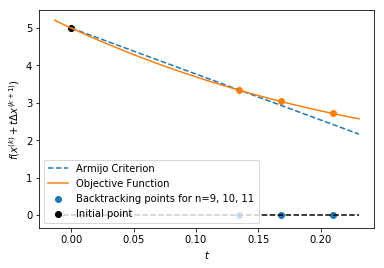

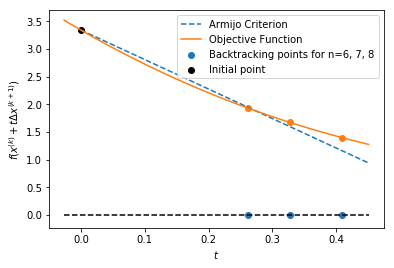

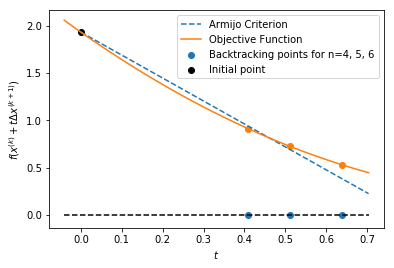

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
import matplotlib.pyplot as plt

def backtracking(x0, dx, f, df0, alpha=0.2, beta=0.8, verbose=False):
    '''
    Backtracking for general functions with illustrations
    :param x0: Previous point from backtracking, or initial guess
    :param dx: Incremental factor for updating x0
    :param f: Objective function
    :param df0: Gradient of f at x0
    :param alpha: Sloping factor of stopping criterion
    :param beta: "Agressiveness" parameter for backtracking steps
    :param verbose: Boolean for providing plots and data
    :return: x1, the next iterate in backtracking
    '''

    # Note that the definition below requires that dx and df0 have the same shape
    delta = alpha * np.sum(dx * df0) # A general, but memory intensive inner product
    
    t = 1 # Initialize t=beta^0
    f0 = f(x0) # Evaluate for future use
    x = x0 + dx # Initialize x_{0, inner}
    fx = f(x)
    
    if verbose:
        n=0
        xs = [x]
        fs = [fx]
        ts = [1] * 3
    
    while (not np.isfinite(fx)) or f0 + delta * t < fx:
        t = beta * t
        x = x0 + t * dx
        fx = f(x)
    ###################################### 
    
        if verbose:
            n += 1
            xs.append(x)
            fs.append(fx)
            ts.append(t)
            ts.pop(0)
            
    if verbose:
        # Display the function along the line search direction as a function of t
        s = np.linspace(-0.1*ts[-1], 1.1*ts[0], 100)
        xi = [0, 1.1*ts[0]]
        fxi = [f0, f0 + 1.1*ts[0]*delta]   
        y = np.zeros(len(s))
        
        for i in range(len(s)):
            y[i] = f(x0 + s[i]*dx) # Slow for vectorized functions

        plt.figure('Backtracking illustration')
        arm, =plt.plot(xi, fxi, '--', label='Armijo Criterion')
        fcn, =plt.plot(s, y, label='Objective Function')
        plt.plot([s[0], s[-1]], [0, 0], 'k--')
        pts =plt.scatter(ts, [0 for p in ts], label='Backtracking points for n=%d, %d, %d' % (n, n+1, n+2))
        plt.scatter(ts, [f(x0 + q*dx) for q in ts] , label='Backtracking values for n=%d, %d, %d' % (n, n+1, n+2))
        init =plt.scatter([0], [f0], color='black', label='Initial point')
        plt.xlabel('$t$')
        plt.ylabel('$f(x^{(k)}+t\Delta x^{(k+1)})$')
        plt.legend(handles=[arm, fcn, pts, init])
        plt.show()
        
        return x, xs, fs
    
    else:
        return x
    
def procPointValue(p, f):
    x = []
    y = []
    z = []
    for i in range(len(f)):
        x.append(p[i][0])
        y.append(p[i][1])
        z.append(f[i])
    
    return np.vstack([x, y, z]).T
        

fun = lambda x: (2 + 8*x[1]*x[1] + (x[0]-2)**2 * ((x[0]+2)**2+1))/20
dfun = lambda x: np.array([((x[0]-2)*((x[0]+2)**2+1) + (x[0]-2)**2 * (x[0]+2)) / 10, 4*x[1]/5])

x0 = np.array([3, 3])
dx = -dfun(x0)

alpha = 0.8
beta = 0.8

x1, xs1, fs1 = backtracking(x0, dx, fun, dfun(x0), alpha=alpha, beta=beta, verbose=True)
x2, xs2, fs2 = backtracking(x1, -dfun(x1), fun, dfun(x1), alpha=alpha, beta=beta, verbose=True)
x3, xs3, fs3 = backtracking(x2, -dfun(x2), fun, dfun(x2), alpha=alpha, beta=beta, verbose=True)

bt1 = procPointValue(xs1, fs1)
bt1pts = procPointValue(xs1, [0]*len(fs1))
jsglobal(BT1=bt1)
jsglobal(BT1PTS=bt1pts)

bt2 = procPointValue(xs2, fs2)
bt2pts = procPointValue(xs2, [0]*len(fs2))
jsglobal(BT2=bt2)
jsglobal(BT2PTS=bt2pts)

bt3 = procPointValue(xs3, fs3)
bt3pts = procPointValue(xs3, [0]*len(fs3))
jsglobal(BT3=bt3)
jsglobal(BT3PTS=bt3pts)

In [13]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return (2 + 8*y*y + Math.pow(x-2,2)*(Math.pow(x+2,2)+1))/20;
    }
    
    var dfcnx = function(x, y) {
        return ((x-2)*(Math.pow(x+2,2)+1) + Math.pow(x-2,2)*(x+2))/10;
    }
    
    var dfcny = function(x, y) {
        return 4*y/5;
    }
    
    var pt = [3, 3];
    var f0 = fcn(pt[0], pt[1]);
    var dx = [-dfcnx(pt[0], pt[1]), -dfcny(pt[0], pt[1])];
    var delta = -0.8 * (dx[0]*dx[0] + dx[1]*dx[1]);
    
    var view = plotGraph(mathbox, fcn);
    addPoint(view, [3, 3, 0], 0x3090FF, '(3,3)');
    addPoint(view, [3, 3, 5], 0xFF9030, '(3,3,5)');
    addSequence(view, BT1PTS, 0x000000);
    addSequence(view, BT1, 0xFF8C00);
    addSegment(view, [pt[0], pt[1], 0], [pt[0]+dx[0], pt[1]+dx[1], 0], 0x00000);
    addSegment(view, [pt[0], pt[1], f0], [pt[0]+dx[0], pt[1]+dx[1], f0 + delta], 0xFF8C00);
    addCurve(view,
             [-0.1, 2.1],
             function(t){return pt[0] + t*dx[0];},
             function(t){return pt[1] + t*dx[1];},
             function(t){return fcn(pt[0] + t*dx[0], pt[1] + t*dx[1]);},
             0xFF4500
            );
    
    
})


<IPython.core.display.Javascript object>

In [14]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return (2 + 8*y*y + Math.pow(x-2,2)*(Math.pow(x+2,2)+1))/20;
    }
    
    var dfcnx = function(x, y) {
        return ((x-2)*(Math.pow(x+2,2)+1) + Math.pow(x-2,2)*(x+2))/10;
    }
    
    var dfcny = function(x, y) {
        return 4*y/5;
    }
    
    var pt = [BT1PTS[BT1PTS.length-1][0], BT1PTS[BT1PTS.length-1][1]];
    var f0 = fcn(pt[0], pt[1]);
    var dx = [-dfcnx(pt[0], pt[1]), -dfcny(pt[0], pt[1])];
    var delta = -0.8 * (dx[0]*dx[0] + dx[1]*dx[1]);
    
    var view = plotGraph(mathbox, fcn);
    addPoint(view, [pt[0], pt[1], 0], 0x3090FF, '(' + pt[0].toFixed(2) + ',' + pt[1].toFixed(2) + ')');
    addPoint(view, [pt[0], pt[1], f0], 0xFF9030, '(' + pt[0].toFixed(2) + ',' + pt[1].toFixed(2) + ',' + f0.toFixed(2) + ')');
    addSequence(view, BT2PTS, 0x000000);
    addSequence(view, BT2, 0xFF8C00);
    addSegment(view, [pt[0], pt[1], 0], [pt[0]+dx[0], pt[1]+dx[1], 0], 0x00000);
    addSegment(view, [pt[0], pt[1], f0], [pt[0]+dx[0], pt[1]+dx[1], f0 + delta], 0xFF8C00);
    addCurve(view,
             [-0.1, 2.1],
             function(t){return pt[0] + t*dx[0];},
             function(t){return pt[1] + t*dx[1];},
             function(t){return fcn(pt[0] + t*dx[0], pt[1] + t*dx[1]);},
             0xFF4500
            );
    
    
})


<IPython.core.display.Javascript object>

In [15]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return (2 + 8*y*y + Math.pow(x-2,2)*(Math.pow(x+2,2)+1))/20;
    }
    
    var dfcnx = function(x, y) {
        return ((x-2)*(Math.pow(x+2,2)+1) + Math.pow(x-2,2)*(x+2))/10;
    }
    
    var dfcny = function(x, y) {
        return 4*y/5;
    }
    
    var pt = [BT2PTS[BT2PTS.length-1][0], BT2PTS[BT2PTS.length-1][1]];
    var f0 = fcn(pt[0], pt[1]);
    var dx = [-dfcnx(pt[0], pt[1]), -dfcny(pt[0], pt[1])];
    var delta = -0.8 * (dx[0]*dx[0] + dx[1]*dx[1]);
    
    var view = plotGraph(mathbox, fcn);
    addPoint(view, [pt[0], pt[1], 0], 0x3090FF, '(' + pt[0].toFixed(2) + ',' + pt[1].toFixed(2) + ')');
    addPoint(view, [pt[0], pt[1], f0], 0xFF9030, '(' + pt[0].toFixed(2) + ',' + pt[1].toFixed(2) + ',' + f0.toFixed(2) + ')');
    addSequence(view, BT3PTS, 0x000000);
    addSequence(view, BT3, 0xFF8C00);
    addSegment(view, [pt[0], pt[1], 0], [pt[0]+dx[0], pt[1]+dx[1], 0], 0x00000);
    addSegment(view, [pt[0], pt[1], f0], [pt[0]+dx[0], pt[1]+dx[1], f0 + delta], 0xFF8C00);
    addCurve(view,
             [-0.1, 2.1],
             function(t){return pt[0] + t*dx[0];},
             function(t){return pt[1] + t*dx[1];},
             function(t){return fcn(pt[0] + t*dx[0], pt[1] + t*dx[1]);},
             0xFF4500
            );
    
    
})

<IPython.core.display.Javascript object>

Alternatively, we can also use a constant step size for gradient descent. This approximates a continuous **gradient flow**


#### Theorem: Suppose $f\in C^2(\mathbb{R}^2)$ is convex and also that there is an $M>0$ such that $ f^{\prime\prime}(x)\vert\leq M$ for all $x\in\mathbb{R}$. If $x^{(0)}\in\mathbb{R}$ and $x^{(k)}$ are the iterates obtained from successively applying backtracking with steepest descent increment, then there is a constant $C>0$ such that
$$
f(x^{(k)})-f(x^\ast) \leq \frac{C}{k}
$$

This is actually a very slow convergence rate for the class of functions $f\in C^2(\mathbb{R})$ with bounded second derivative. This leads us to consider an accelerated version of the backtracking procedure.

In [16]:
%%javascript 

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return (2 + 8*y*y + Math.pow(x-2,2)*(Math.pow(x+2,2)+1))/20;
    }
    
    var dfcnx = function(x, y) {
        return ((x-2)*(Math.pow(x+2,2)+1) + Math.pow(x-2,2)*(x+2))/10;
    }
    
    var dfcny = function(x, y) {
        return 4*y/5;
    }
    
    var d = new Date();
    var start = d.getTime();
    var xk = -3*(2*Math.random()-1);
    var yk = 3;
    var step = 0.01

    var view = plotGraph(mathbox, fcn);
    
    view.area({
      id: 'gradient flow',
      width: 16,
      height: 16,
      axes: [1, 3],
      expr: function (emit, x, y, i, j) {
          emit(y-0.1*dfcny(x, y),0,x-0.1*dfcnx(x, y)); // End of Arrow
          emit(y,0,x); // Beginning of Arrow
      },
      items: 2,
      channels: 3,
    }).vector({
      color: 0x00FF00,
      width: 5,
      start: true,
    });

    
    view.array({width: 4,
                items: 2,
                channels: 3,
                expr: function (emit, i, t) {
                    var di = new Date();
                    var now = di.getTime();
                    if (di - start < 6000) {
                        var grad = [dfcnx(xk, yk), dfcny(xk, yk)];
                        xk = xk - step * grad[0];
                        yk = yk - step * grad[1];
                    } else {
                        d = new Date();
                        start = d.getTime();
                        xk = -3*(2*Math.random()-1);
                        yk = 3;
                    }
                    emit(yk,0,xk);
                },
               })
        .point({color:  0x3090FF,
                points: '<',
                size: 15,
                depth: .5,
                zBias: 50
               })
        .text({font: 'Helvetica',
               style: 'bold',
               width:  16,
               height: 5,
               depth:  2,
               expr: function (emit, i, j, k, time) {
                   emit('(x(k), y(k))');
               },
              })
        .label({color: 0x3090FF,
                snap: false,
                outline: 2,
                size: 24,
                offset: [0, -32],
                depth: .5,
                zIndex: 1,
               });
    
    view.array({width: 4,
                items: 2,
                channels: 3,
                expr: function (emit, i, t) {
                    emit(yk, fcn(xk,yk), xk);
                },
               })
        .point({color:  0xFF9030,
                points: '<',
                size: 15,
                depth: .5,
                zBias: 50
               })
        .text({font: 'Helvetica',
               style: 'bold',
               width:  16,
               height: 5,
               depth:  2,
               expr: function (emit, i, j, k, time) {
                   emit('(x(k), y(k), f(x(k), y(k)))');
               },
              })
        .label({color: 0xFF9030,
                snap: false,
                outline: 2,
                size: 24,
                offset: [0, -32],
                depth: .5,
                zIndex: 1,
               });
    
    
})

<IPython.core.display.Javascript object>

#### Theorem: Suppose $f\in C^2(\mathbb{R})$ is convex and also that there is an $M>0$ such that $\vert f^{\prime\prime}(x)\vert\leq M$ for all $x\in\mathbb{R}$. Then, for the sequence $x^{(1)}, x^{(2)}, x^{(3)},\ldots$ produced by accelerated backtracking, there is a constant $C>0$ such that
$$
f(x^{(k)})-f(x^\ast) \leq \frac{C}{k^2}.
$$
Nesterov demonstrated that this is in fact the optimal rate of convergence for any first order method on this class of functions.

#### Theorem: GD converges for almost all starting points and all non-crazy functions

## Newton Search Directions

The generalization of the Newton's direction in $\mathbb{R}^2$ is
$$
\Delta {\bf x}^{(k+1)} = -\left(\nabla^2 f({\bf x}^{(k)})\right)^{-1} \nabla f({\bf x}^{(k)}) 
$$
where
$$
\begin{pmatrix}
a & b \\
c & d
\end{pmatrix}^{-1} = \frac{1}{ad-bc} \begin{pmatrix}
d & -b\\
-c & a
\end{pmatrix}
$$
is the **inverse matrix** for any matrix with non-zero determinant. This formula is derived by finding the critical point of the second order Taylor approximation at ${\bf x}^{(k)}$. The gradient of
$$
p({\bf x}) = f({\bf x})^{(k)}) + \nabla f({\bf x})^{(k)})^T({\bf x}-{\bf x}^{(0)}) + \frac{1}{2}({\bf x}-{\bf x}^{(0)})^T\nabla^2 f({\bf x})^{(k)})({\bf x}-{\bf x}^{(0)})
$$
is
$$
\nabla p({\bf x}) = \nabla f({\bf x}^{(k)}) + \nabla^2 f({\bf x}^{(k)})({\bf x}-{\bf x}^{(0)}).
$$

is a way to get even faster convergence to solutions, but it requires evaluation of $f^{\prime\prime}$ at each step. The Newton iterates are defined by
$$
x^{(k+1)} = x^{(k)} - \frac{f^\prime(x^{(k)})}{f^{\prime\prime}(x^{(k)})}
$$

#### Theorem (Quadratic Convergence of Newton's Method): Suppose $f\in C^3(\mathbb{R})$, $f^\prime(x^\ast)=0$, there is a constant $c>0$ such that $f^{\prime\prime}(x^\ast)\geq c$, and there is a constant $K>0$ such that $\vert f^{\prime\prime\prime}(x)\vert \leq K$ for all $x\in\mathbb{R}$. If $x^{(0)}$ satisfies $\vert x^{(0)}-x^\ast\vert\leq \frac{2c}{3k}$, then the Newton iterates initialized with $x^{(0)}$ satisfy $\vert x^{(k)}-x^\ast\vert\leq \frac{2c}{3K}$ and $\vert x^{(k+1)} - x^\ast\vert \leq \frac{3K}{2c} \vert x^{(k)}-x^\ast\vert^2$ for all $k\geq 0$. 

The **quadratic convergence** here is also known as **doubly exponential convergence** since it implies 
$$
\vert x^{(k)}-x^\ast\vert \leq \gamma^{2^k-1}\vert x^{(0)}-x^\ast\vert
$$
for some $\gamma\in(0,1)$. However, convergence in this theorem is contingent on the fact that $\vert x^{(0)}-x^\ast\vert < \frac{2c}{3K}$. It turns out that Newton's method need to converge at all.

In [17]:
%%javascript 

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return (2 + 8*y*y + Math.pow(x-2,2)*(Math.pow(x+2,2)+1))/20;
    };
    
    var dfcnx = function(x, y) {
        return ((x-2)*(Math.pow(x+2,2)+1) + Math.pow(x-2,2)*(x+2))/10;
    };
    
    var dfcny = function(x, y) {
        return 4*y/5;
    };
    
    var d2fcn = function(x, y) {
        return [[(Math.pow(x+2,2) + 1 + 4*(x*x-1) + Math.pow(x-2,2))/10,0], [0, 0.8]];
    };
    
    var nStep = function(x, y) {
        var H11=(Math.pow(x+2,2) + 1 + 4*(x*x-1) + Math.pow(x-2,2))/10;
        var H22=0.8;
        return [dfcnx(x,y)/H11, dfcny(x,y)/H22];
    };
    
    var d = new Date();
    var start = d.getTime();
    var xk = -3*(2*Math.random()-1);
    var yk = 3;
    var step = 0.01

    var view = plotGraph(mathbox, fcn);
    
    view.area({
      id: 'Newton flow',
      width: 16,
      height: 16,
      axes: [1, 3],
      expr: function (emit, x, y, i, j) {
          var nstep=nStep(x, y);
          emit(y-0.1*nstep[1], 0, x-0.1*nstep[0]); // End of Arrow
          emit(y, 0, x); // Beginning of Arrow
      },
      items: 2,
      channels: 3,
    }).vector({
      color: 0x00FF00,
      width: 5,
      start: true,
    });

    
    view.array({width: 4,
                items: 2,
                channels: 3,
                expr: function (emit, i, t) {
                    var di = new Date();
                    var now = di.getTime();
                    if (di - start < 6000) {
                        var nstep = nStep(xk, yk);
                        xk = xk - step * nstep[0];
                        yk = yk - step * nstep[1];
                    } else {
                        d = new Date();
                        start = d.getTime();
                        xk = -3*(2*Math.random()-1);
                        yk = 3;
                    }
                    emit(yk, 0, xk);
                },
               })
        .point({color:  0x3090FF,
                points: '<',
                size: 15,
                depth: .5,
                zBias: 50
               })
        .text({font: 'Helvetica',
               style: 'bold',
               width:  16,
               height: 5,
               depth:  2,
               expr: function (emit, i, j, k, time) {
                   emit('(x(k), y(k))');
               },
              })
        .label({color: 0x3090FF,
                snap: false,
                outline: 2,
                size: 24,
                offset: [0, -32],
                depth: .5,
                zIndex: 1,
               });
    
    view.array({width: 4,
                items: 2,
                channels: 3,
                expr: function (emit, i, t) {
                    emit(yk, fcn(xk,yk), xk);
                },
               })
        .point({color:  0xFF9030,
                points: '<',
                size: 15,
                depth: .5,
                zBias: 50
               })
        .text({font: 'Helvetica',
               style: 'bold',
               width:  16,
               height: 5,
               depth:  2,
               expr: function (emit, i, j, k, time) {
                   emit('(x(k), y(k), f(x(k), y(k)))');
               },
              })
        .label({color: 0xFF9030,
                snap: false,
                outline: 2,
                size: 24,
                offset: [0, -32],
                depth: .5,
                zIndex: 1,
               });
    
    
})

<IPython.core.display.Javascript object>

# Part VII: Constrained Bivariate Optimization

Lagrange multipliers provide a complete picture for bivariate optimization with one equality constraint. On the other hand, it is not immediately clear how to solve such programs with iterative methods. This is because such iterative methods require that we increase the dimensionality of our optimization program, which we will do in the future.

## Optimization with a single inequality constraint

Inequality constrained optimization is an interesting mixture of the unconstrained and inequality constrained programs. Consider the program

$$
\min \frac{1}{2}\Vert {\bf x} - {\bf 1}\Vert^2 \text{ subject to } \Vert {\bf x}\Vert^2\leq 1,
$$

where ${\bf 1}\in\mathbb{R}^2$ is the vector whose entries are all $1$'s. If ${\bf x}^\ast$ is a solution to this program, then either $\Vert x^{\ast}\Vert^2=1$ for $\Vert x^{\ast}\Vert^2 < 1$. In the former case, we say that the constraint is **binding** and in the latter case we say that the constraint is **non-binding** or **not binding**. More informally, we say that the solution is **on the boundary** of the feasible region or is **inside** the feasible region to convey the geometric intuition. 

In [18]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return (Math.pow(x-1,2) + Math.pow(y-1, 2))/2;
    }
    
    var view = plotGraph(mathbox, fcn, 'x', 'y', 'f(x,y)', [[-2, 2], [-1, 3], [-2, 2]]);
     
    addClosedCurve(view,
             [0, 6.4],
             function(t){return Math.cos(t);},
             function(t){return Math.sin(t);},
             function(t){return 0;},
             0x3090FF
            );
    
    addClosedCurve(view,
             [0, 6.4],
             function(t){return Math.cos(t);},
             function(t){return Math.sin(t);},
             function(t){return fcn(Math.cos(t), Math.sin(t));},
             0xFF8C00
            );
    
    addSurface(view, 
               [0, 6.4],
               [0, 1],
              function(s, t) {return t*Math.cos(s);},
              function(s, t) {return t*Math.sin(s);},
              function(s, t) {return 0;},
              0x3090FF,
              0.75)
    
    addSurface(view, 
               [0, 6.4],
               [0, 1],
              function(s, t) {return t*Math.cos(s);},
              function(s, t) {return t*Math.sin(s);},
              function(s, t) {return fcn(t*Math.cos(s), t*Math.sin(s));},
              0xFF8C00,
              0.9)
})

<IPython.core.display.Javascript object>


Let's set $f({\bf x})=\frac{1}{2}\Vert {\bf x} - {\bf 1}\Vert^2$ and $h({\bf x})=\Vert x\Vert^2 -1$. Note that the constraint for this program is equivalent to $h({\bf x})\leq 0$. If the constraint is binding, then ${\bf x}^\ast$ is also a solution to
$$
\min \frac{1}{2}\Vert {\bf x} - {\bf 1}\Vert^2\text{ subject to } h({\bf x})=0,
$$
and hence the theory of Lagrange multipliers applies. If the constraint is not binding, we note that $h({\bf x})$ is a continuous function and thus
$$
\{{\bf x}\in \mathbb{R}^2: h({\bf x})<0\}
$$
is an *open* set. Consequently, ${\bf x}^\ast$ must statisfy the necessary conditions for optimality in the *unconstrained program*
$$
\min \frac{1}{2}\Vert {\bf x} - {\bf 1}\Vert^2
$$
in addition to the constraint $\Vert {\bf x}^\ast\Vert \leq 1$. In summary, we have that either:

1. $h({\bf x}^\ast)=0$, in which case $\nabla h({\bf x}^\ast)\not={\bf 0}$ implies $\displaystyle \nabla f({\bf x}) + \lambda \nabla h({\bf x}^\ast)=0$ or
2. $\nabla f({\bf x}^\ast)=0$ and $\Vert {\bf x}^\ast\Vert \leq 1$ ($h({\bf x}^\ast)=0$). 

Therefore, we need to identify all points satisfying either of the following conditions:

1. $\nabla f({\bf x})={\bf 0}$ and $h({\bf x})<0$, 
2. $h({\bf x})=0$, $\nabla h({\bf x})\not={\bf 0}$, and there is a $\lambda\in\mathbb{R}$ with $\nabla f({\bf x})+\lambda \nabla h({\bf x})={\bf 0}$, or
3. $h({\bf x})=0$, but $\nabla h({\bf x})={\bf 0}$.

In the second case, we should also have that $\lambda\geq 0$. This is because $\lambda < 0$ implies that $f({\bf x}) = -\lambda \nabla h({\bf x})$, so $\nabla f({\bf x})$ and $\nabla h({\bf x})$ point in the same direction. Consequently, they are both locally decreasing in the direction $-\nabla f({\bf x})$, and hence ${\bf x}$ is not a local minimizer.

We also note that $\nabla f({\bf x}^\ast)=0$ is the same as $\nabla f({\bf x})+\lambda \nabla h({\bf x})={\bf 0}$ with $\lambda =0$. We also observe that, if $\lambda>0$ and $\nabla h({\bf x}^\ast)\not={\bf 0}$, then $\nabla f({\bf x}^\ast)\not=0$, and hence $h({\bf x}^\ast)=0$. Otherwise, ${\bf x}^\ast$ is a point in an open subset of $\mathbb{R}$ which is a local minimizer failing the necessary conditions for optimality. 

On the other hand, if $h({\bf x}^\ast)<0$, $\lambda=0$ is required in the equation $\nabla f({\bf x})+\lambda \nabla h({\bf x})={\bf 0}$. Consequently, we can say that either $h({\bf x}^\ast)<0$ or $\lambda>0$, but both cannot hold simultaneously. This propery is called **complementary slackness**, and it can be encoded by simply imposing the condition that $\lambda h({\bf x})=0$.

From this discussion, we see that (if $\nabla h({\bf x}^\ast)\not={\bf 0}$) there is a $\lambda\in\mathbb{R}$ such that

1. **(Stationarity)** $\nabla f({\bf x}^\ast)+\lambda \nabla h({\bf x}^\ast)={\bf 0}$
2. **(Primal Feasibility)** $h({\bf x}^\ast)\leq 0$
3. **(Dual Feasibility)** $\lambda \geq 0$
4. **(Complementary Slackness)** $\lambda h({\bf x}^\ast)=0$

These conditions are called the **Karush-Kuhn-Tucker Conditions** or **KKT Conditions**. They imply the following analytic procedure for solving constrained optimization programs with inequality constraints:

1. Determine all points such that $\nabla h({\bf x})={\bf 0}$.
2. Determine all points satisfying the $\nabla h({\bf x})\not={\bf 0}$ and the KKT conditions.
3. Use brute force search on the points from 1 and 2 to determine the solutions.

Returning to our original problem, we see that the only point satisfying $\nabla h({\bf x})={\bf 0}$ is ${\bf x}={\bf 0}$ (which is feasible). To determine the remaining possibilities, we observe that the KKT conditions are

1. ${\bf x} - {\bf 1} +\lambda {\bf x} = {\bf 0}$
2. $\Vert {\bf x}\Vert^2\leq 1$
3. $\lambda \geq 0$
4. $\lambda(\Vert{\bf x}\Vert^2-1)=0$

Even for small problems, this is a large number of conditions, so it is important to keep the geometry of the problem in mind. We simply check for solutions *inside* the feasible region ($h({\bf x})<0$) and *on the boundary* of the feasible region ($h({\bf x})=0$). This corresponds to setting either $\lambda=0$ or $h({\bf x})=0$. 

If $\lambda=0$, then the stationarity implies ${\bf x}={\bf 1}$, which contradicts dual feasibility since $\Vert {\bf 1}\Vert^2=2\not\leq 1$. On the other hand, if $h({\bf x})=0$, stationarity implies ${\bf x} = \frac{1}{1+\lambda}{\bf 1}$, and then $h({\bf x})=\Vert {\bf x}\Vert^2-1=0$ implies that $\lambda = \sqrt{2}-1\geq 0$. Since we have found a $\lambda$ and ${\bf x}$ satisfying all the KKT conditions, ${\bf x}=\frac{1}{\sqrt{2}}{\bf 1}$ is a possible solution. This illustrates the general pattern in solving the KKT conditions: we slowly work to either eliminate possibilities through contradiction, or we obtain possibilities by methodically eliminating variables.

Now, we have found that ${\bf 0}$ and $\frac{1}{\sqrt{2}}{\bf 1}$ are the only possible solutions to the program. To determine the true solution, we plug these in to obtain $f({\bf 0})= 1$ and $f(\frac{1}{\sqrt{2}}{\bf 1})=\frac{3}{2}-\sqrt{2}$. Since $\frac{3}{2}-\sqrt{2}<1$, we conclude that ${\bf x}^\ast = \frac{1}{\sqrt{2}}{\bf 1}$ is the minimizer.


## Optimization with multiple inequality constraints

Consider the program
$$
\min \frac{1}{2} \Vert {\bf x}-{\bf 1}\Vert^2\text{ subject to } x_1\geq 0,\: x_2\geq 0,\:2x_1+x_2\leq 1.
$$
we can set $f({\bf x})=\frac{1}{2} \Vert {\bf x}-{\bf 1}\Vert^2$, $h_1({\bf x})=-x_1$, $h_2({\bf x})=-x_2$, and $h_3({\bf x})=2x_1+x_2 - 1$ to rewrite this program as
$$
\min f({\bf x})\text{ subject to } h_1({\bf x})\leq 0,\:h_2({\bf x})\leq 0,\:h_3({\bf x})\leq 0.
$$
Geometrically, we are optimizing over a triangle.

In [19]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(x, y) {
        return (Math.pow(x-1,2) + Math.pow(y-1, 2))/2;
    }
    
    var view = plotGraph(mathbox, fcn, 'x', 'y', 'f(x,y)', [[0, 1], [-1, 1], [0, 1]]);
     
    addClosedCurve(view,
             [0, 1/2],
             function(t){return t;},
             function(t){return 0;},
             function(t){return 0;},
             0x3090FF
            );
    
    addClosedCurve(view,
             [0, 1],
             function(t){return 0;},
             function(t){return t;},
             function(t){return 0;},
             0x3090FF
            );
    
    addClosedCurve(view,
             [0, 1],
             function(t){return t/2;},
             function(t){return (1-t);},
             function(t){return 0;},
             0x3090FF
            );
    
    addSurface(view, 
               [0, 1/2],
               [0, 1],
              function(s, t) {return s;},
              function(s, t) {return t*(1-2*s);},
              function(s, t) {return 0;},
              0x3090FF,
              0.75)
    
    addClosedCurve(view,
             [0, 1/2],
             function(t){return t;},
             function(t){return 0;},
             function(t){return fcn(t, 0);},
             0xFF8C00
            );
    
    addClosedCurve(view,
             [0, 1],
             function(t){return 0;},
             function(t){return t;},
             function(t){return fcn(0, t);},
             0xFF8C00
            );
    
    addClosedCurve(view,
             [0, 1],
             function(t){return t/2;},
             function(t){return (1-t);},
             function(t){return fcn(t/2, 1-t);},
             0xFF8C00
            );
    
    addSurface(view, 
               [0, 1/2],
               [0, 1],
              function(s, t) {return s;},
              function(s, t) {return t*(1-2*s);},
              function(s, t) {return fcn(s, t*(1-2*s));},
              0xFF8C00,
              0.9)
})

<IPython.core.display.Javascript object>

We proceed by using the same intution we used when optimizing over the unit disc: check for degenerate points, points on the inside, and points on the boundary. However, we now see that there is a new possibility: the corners of the triangle involve two constraints that are simultaneously binding. Since this only happens for three points, we simply add them to the list that we will check with brute force, and defer the general theory until we are working in more dimensions.

The only other possibilities are that the solution occurs inside the region or on one of the edges of the triangle. We note that
$$
\nabla h_1({\bf x})=\begin{pmatrix}
-1\\
0
\end{pmatrix},\:\nabla h_2({\bf x})=\begin{pmatrix}
0\\
-1
\end{pmatrix},\:\nabla h_3({\bf x})=\begin{pmatrix}
2\\
1
\end{pmatrix},
$$
and since none of these are zero, we know that Lagrange multipliers must exist whenever only one of the constraints is binding. We can succintly encode all such by state that, if ${\bf x}^\ast$ is a solution to this program, there are $\lambda_1, \lambda_2$, and $\lambda_3$ such that

1. **(Stationarity)** $\nabla f({\bf x}^\ast) + \lambda_1 \nabla h_1({\bf x}^\ast) + \lambda_2 \nabla h_2({\bf x}^\ast) + \lambda_3 \nabla h_3({\bf x}^\ast)={\bf 0}$
2. **(Primal Feasibility)** $h_1({\bf x}^\ast)\leq 0, h_2({\bf x}^\ast)\leq 0, h_3({\bf x}^\ast)\leq 0$
3. **(Dual Feasibility)** $\lambda_1\geq 0, \lambda_2\geq 0, \lambda_3\geq 0$
4. **(Complementary Slackness)** $\lambda_1h_1({\bf x}^\ast)=\lambda_2h_2({\bf x}^\ast)=\lambda_3h_3({\bf x}^\ast)=0$

These are the *KKT conditions* for this program. Later, we will see that the KKT conditions also apply to the corners. Now, the complementary slackness conditions encode the fact that we need to check the different parts of the boundary of the feasible region.

# Part VIII: Iterative Methods for Constrained Optimization

For now, we only consider iterative methods for constrained optimization in the case of inequality constraints. We can again employ the log-barrier method to turn a program of the form
$$
\min f({\bf x})\text{ subject to } h({\bf x})\leq 0
$$
to a sequence of programs of the form
$$
\min f({\bf x}) - \frac{1}{t}\log(-h({\bf x})).
$$

In [20]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var tlb = 0.0625
    
    var fcn = function(x, y) {
        return (Math.pow(x-1,2) + Math.pow(y-1, 2))/2;
    }
    
    var logbarrier = function(x, y) {
        return -Math.log(1 - x*x - y*y);
    }
    
    var view = plotGraph(mathbox, fcn, 'x', 'y', 'f(x,y)', [[-1.5, 1.5], [-1, 3], [-1.5, 1.5]]);
     
    addClosedCurve(view,
             [0, 6.4],
             function(t){return Math.cos(t);},
             function(t){return Math.sin(t);},
             function(t){return 0;},
             0x3090FF
            );
    
    addSurface(view, 
               [0, 6.4],
               [0, 1],
              function(s, t) {return t*Math.cos(s);},
              function(s, t) {return t*Math.sin(s);},
              function(s, t) {return 0;},
              0x3090FF,
              0.75)
    
    addSurface(view, 
               [0, 6.4],
               [0, 0.99],
              function(s, t) {return t*Math.cos(s);},
              function(s, t) {return t*Math.sin(s);},
              function(s, t) {return fcn(t*Math.cos(s), t*Math.sin(s)) + tlb*logbarrier(t*Math.cos(s), t*Math.sin(s));},
              0xFF8C00,
              0.9)
})

<IPython.core.display.Javascript object>

This barrier function will confine iterations to the interior of the feasible region for each $t>0$, and we may use gradient descent or Newton's method with backtracking to solve each of the subproblems. However, we must first identify a point inside the feasible region. That is, we need to obtain an ${\bf x}^{(0)}$ with $h({\bf x}^{(0)})<0$. In many cases, this is very simple. For example, with $h({\bf x})=\Vert x\Vert^2-1$, we see that ${\bf 0}$ is **strictly feasible**. However, with many constraints it may not be easy to immediately find such a point, and the program itself may be infeasible. When we begin general optimization theory, we will provide a **Phase I** procedure for finding an interior point that can be used to initialize the log-barrier method.

For now, let us assume that we are given ${\bf x}^{(0)}$ with $h({\bf x}^{(0)})<0$. We can use gradient descent to solve each subproblem. 

/Users/n8/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log


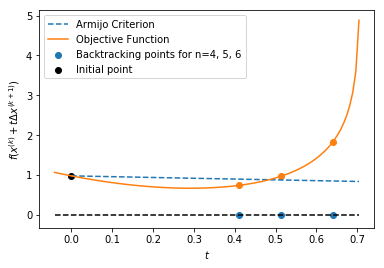

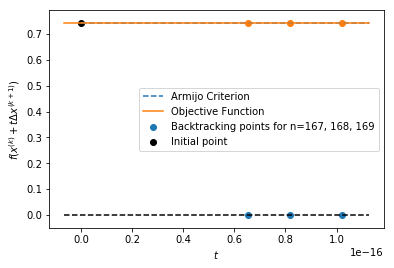

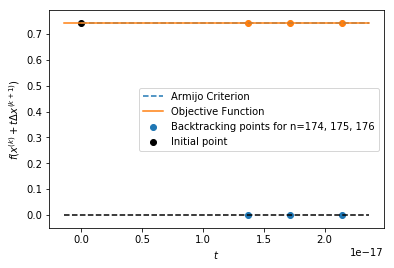

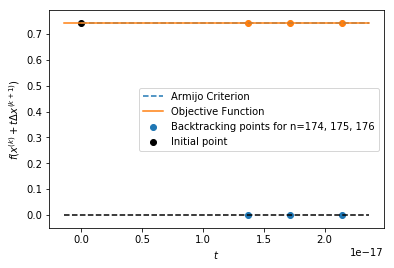

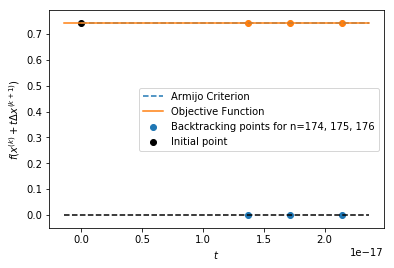

/Users/n8/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in log


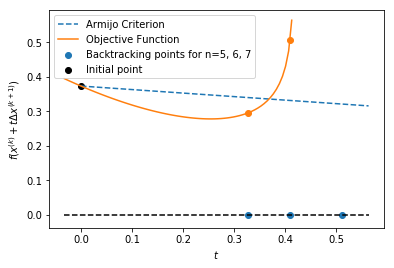

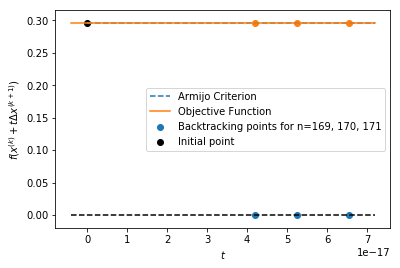

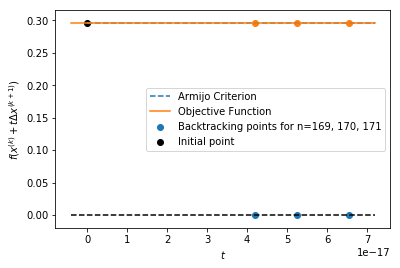

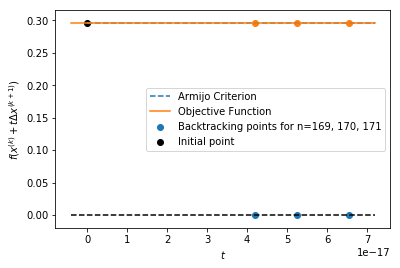

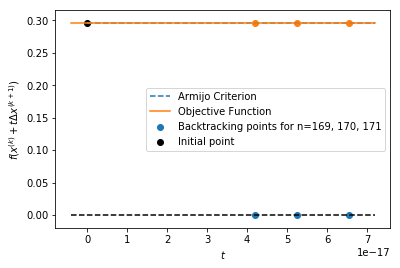

/Users/n8/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in log


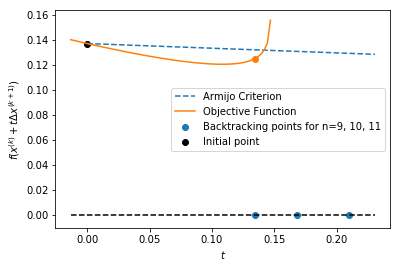

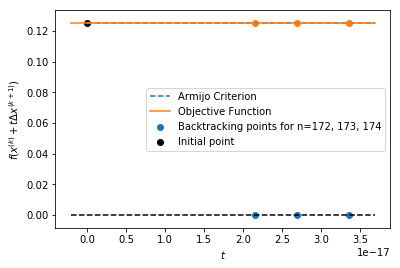

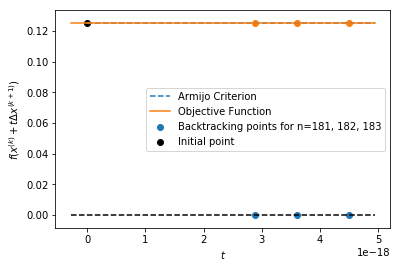

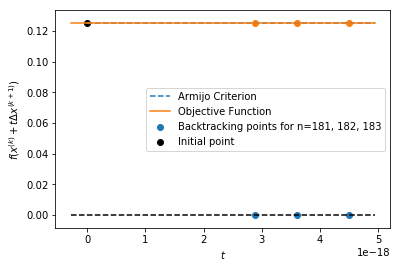

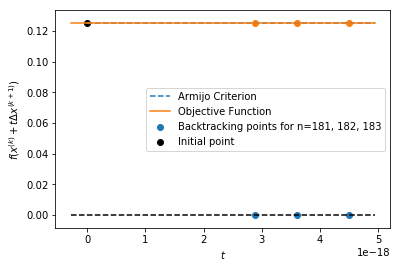

[ 0.42369764  0.39550236]
[ 0.65435518  0.63261633]
[ 0.71098203  0.69182089]


In [21]:
import numpy as np
import matplotlib.pyplot as plt

def backtracking(x0, dx, f, df0, alpha=0.2, beta=0.8, verbose=False):
    '''
    Backtracking for general functions with illustrations
    :param x0: Previous point from backtracking, or initial guess
    :param dx: Incremental factor for updating x0
    :param f: Objective function
    :param df0: Gradient of f at x0
    :param alpha: Sloping factor of stopping criterion
    :param beta: "Agressiveness" parameter for backtracking steps
    :param verbose: Boolean for providing plots and data
    :return: x1, the next iterate in backtracking
    '''

    # Note that the definition below requires that dx and df0 have the same shape
    delta = alpha * np.sum(dx * df0) # A general, but memory intensive inner product
    
    t = 1 # Initialize t=beta^0
    f0 = f(x0) # Evaluate for future use
    x = x0 + dx # Initialize x_{0, inner}
    fx = f(x)
    
    if verbose:
        n=0
        xs = [x]
        fs = [fx]
        ts = [1] * 3
    
    while (not np.isfinite(fx)) or f0 + delta * t < fx:
        t = beta * t
        x = x0 + t * dx
        fx = f(x)
    ###################################### 
    
        if verbose:
            n += 1
            xs.append(x)
            fs.append(fx)
            ts.append(t)
            ts.pop(0)
            
    if verbose:
        # Display the function along the line search direction as a function of t
        s = np.linspace(-0.1*ts[-1], 1.1*ts[0], 100)
        xi = [0, 1.1*ts[0]]
        fxi = [f0, f0 + 1.1*ts[0]*delta]   
        y = np.zeros(len(s))
        
        for i in range(len(s)):
            y[i] = f(x0 + s[i]*dx) # Slow for vectorized functions

        plt.figure('Backtracking illustration')
        arm, =plt.plot(xi, fxi, '--', label='Armijo Criterion')
        fcn, =plt.plot(s, y, label='Objective Function')
        plt.plot([s[0], s[-1]], [0, 0], 'k--')
        pts =plt.scatter(ts, [0 for p in ts], label='Backtracking points for n=%d, %d, %d' % (n, n+1, n+2))
        plt.scatter(ts, [f(x0 + q*dx) for q in ts] , label='Backtracking values for n=%d, %d, %d' % (n, n+1, n+2))
        init =plt.scatter([0], [f0], color='black', label='Initial point')
        plt.xlabel('$t$')
        plt.ylabel('$f(x^{(k)}+t\Delta x^{(k+1)})$')
        plt.legend(handles=[arm, fcn, pts, init])
        plt.show()
        
        return x, xs, fs
    
    else:
        return x

# Two steps of the log barrier method

fun = lambda x: ((x[0]-1)**2 + (x[0]-1)**2)/2
dfun = lambda x: x-1

h = lambda x: np.sum(x*x)-1
dh = lambda x: 2*x

lb1 = lambda x: fun(x) - 1*np.log(-h(x))
dlb1 = lambda x: dfun(x) + 1*dh(x)/h(x)

alpha = 0.1
beta = 0.8

x1 = np.zeros((3, 6))
x1[:2,0] = np.array([0.01, -0.01])

x1[:2, 1], xs, fs = backtracking(x1[:2,0], -dlb1(x1[:2,0]), lb1, dlb1(x1[:2,0]), alpha=alpha, beta=beta, verbose=True)
x1[:2, 2], xs, fs = backtracking(x1[:2, 1], -dlb1(x1[:2,1]), lb1, dlb1(x1[:2,1]), alpha=alpha, beta=beta, verbose=True)
x1[:2, 3], xs, fs = backtracking(x1[:2, 2], -dlb1(x1[:2,2]), lb1, dlb1(x1[:2,2]), alpha=alpha, beta=beta, verbose=True)
x1[:2, 4], xs, fs = backtracking(x1[:2, 3], -dlb1(x1[:2,3]), lb1, dlb1(x1[:2,3]), alpha=alpha, beta=beta, verbose=True)
x1[:2, 5], xs, fs = backtracking(x1[:2, 4], -dlb1(x1[:2,4]), lb1, dlb1(x1[:2,4]), alpha=alpha, beta=beta, verbose=True)

lb2 = lambda x: fun(x) - 0.1*np.log(-h(x))
dlb2 = lambda x: dfun(x) + 0.1*dh(x)/h(x)

x2 = np.zeros((3, 6))
x2[:2,0] = x1[:2, 5] # initialize at the output of previous step

x2[:2, 1], xs, fs = backtracking(x2[:2,0], -dlb2(x2[:2,0]), lb2, dlb2(x2[:2,0]), alpha=alpha, beta=beta, verbose=True)
x2[:2, 2], xs, fs = backtracking(x2[:2, 1], -dlb2(x2[:2,1]), lb2, dlb2(x2[:2,1]), alpha=alpha, beta=beta, verbose=True)
x2[:2, 3], xs, fs = backtracking(x2[:2, 2], -dlb2(x2[:2,2]), lb2, dlb2(x2[:2,2]), alpha=alpha, beta=beta, verbose=True)
x2[:2, 4], xs, fs = backtracking(x2[:2, 3], -dlb2(x2[:2,3]), lb2, dlb2(x2[:2,3]), alpha=alpha, beta=beta, verbose=True)
x2[:2, 5], xs, fs = backtracking(x2[:2, 4], -dlb2(x2[:2,4]), lb2, dlb2(x2[:2,4]), alpha=alpha, beta=beta, verbose=True)

lb3 = lambda x: fun(x) - 0.01*np.log(-h(x))
dlb3 = lambda x: dfun(x) + 0.01*dh(x)/h(x)

x3 = np.zeros((3, 6))
x3[:2,0] = x2[:2, 5] # initialize at the output of previous step

x3[:2, 1], xs, fs = backtracking(x3[:2, 0], -dlb3(x3[:2,0]), lb3, dlb3(x3[:2,0]), alpha=alpha, beta=beta, verbose=True)
x3[:2, 2], xs, fs = backtracking(x3[:2, 1], -dlb3(x3[:2,1]), lb3, dlb3(x3[:2,1]), alpha=alpha, beta=beta, verbose=True)
x3[:2, 3], xs, fs = backtracking(x3[:2, 2], -dlb3(x3[:2,2]), lb3, dlb2(x3[:2,2]), alpha=alpha, beta=beta, verbose=True)
x3[:2, 4], xs, fs = backtracking(x3[:2, 3], -dlb3(x3[:2,3]), lb3, dlb2(x3[:2,3]), alpha=alpha, beta=beta, verbose=True)
x3[:2, 5], xs, fs = backtracking(x3[:2, 4], -dlb3(x3[:2,4]), lb3, dlb2(x3[:2,4]), alpha=alpha, beta=beta, verbose=True)


print(x1[:2, 5])
print(x2[:2, 5])
print(x3[:2, 5])


In [22]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var tlb = 1.0
    
    var fcn = function(x, y) {
        return (Math.pow(x-1,2) + Math.pow(y-1, 2))/2;
    }
    
    var logbarrier = function(x, y) {
        return -Math.log(1 - x*x - y*y);
    }
    
    var view = plotGraph(mathbox, fcn, 'x', 'y', 'f(x,y)', [[-1.5, 1.5], [-1, 3], [-1.5, 1.5]]);
     
    addClosedCurve(view,
             [0, 6.4],
             function(t){return Math.cos(t);},
             function(t){return Math.sin(t);},
             function(t){return 0;},
             0x3090FF
            );
    
    addSurface(view, 
               [0, 6.4],
               [0, 1],
              function(s, t) {return t*Math.cos(s);},
              function(s, t) {return t*Math.sin(s);},
              function(s, t) {return 0;},
              0x3090FF,
              0.75)
    
    addSurface(view, 
               [0, 6.4],
               [0, 0.99],
              function(s, t) {return t*Math.cos(s);},
              function(s, t) {return t*Math.sin(s);},
              function(s, t) {return fcn(t*Math.cos(s), t*Math.sin(s)) + tlb*logbarrier(t*Math.cos(s), t*Math.sin(s));},
              0xFF8C00,
              0.9)
    
    addSequence(view, LB1, 0x3090FF);
})

<IPython.core.display.Javascript object>